<a href="https://colab.research.google.com/github/ATOMScience-org/AMPL/blob/master/atomsci/ddm/examples/tutorials/12_AMPL_HPO_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hyperparameter Optimization using AMPL 

# Time to run the notebook: ~ 22 minutes on COLAB with GPU accelerator turned on. 

### Install AMPL packages

In [ ]:
! pip install rdkit-pypi
! pip install deepchem

import deepchem
# print(deepchem.__version__)
! pip install umap
! pip install -U --ignore-installed numba
! pip install umap-learn
! pip install molvs
! pip install bravado

In [ ]:
import deepchem as dc

# get the Install AMPL_GPU_test.sh
!wget 'https://raw.githubusercontent.com/ATOMScience-org/AMPL/master/atomsci/ddm/examples/tutorials/config/install_AMPL_GPU_test.sh' >& /dev/null

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

In [3]:
!wget https://raw.githubusercontent.com/ATOMScience-org/AMPL/master/atomsci/ddm/examples/tutorials/datasets/H1_std.csv >& /dev/null

In [4]:
!pip install hyperopt

### Load packages and dataset

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_context("poster")
sns.set_style("whitegrid")
sns.set_palette("Set2")

import pandas as pd
import os, json, sys, glob, pickle

from atomsci.ddm.pipeline import model_pipeline as mp
from atomsci.ddm.pipeline import parameter_parser as parse
from atomsci.ddm.pipeline import perf_data

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

2021-09-18 16:31:38,939 Model tracker client not supported in your environment; will save models in filesystem only.


In [6]:
h1 = pd.read_csv("H1_std.csv")

In [7]:
h1

,rdkit_smiles,compound_id,NofA,pKi_mean,pKi_std
0,C(#Cc1c2c(nc3ccccc13)CCCCC2)CCN1CCCCC1,CHEMBL66660,1,4.803188,0.471982
1,C(#Cc1cccc(CN2CCOCC2)c1)CCN1CCCCC1,CHEMBL237087,1,5.000000,0.181920
2,C(=C/c1ccccc1)\CN1CCN(C(c2ccccc2)c2ccccc2)CC1,CHEMBL43064,1,8.064392,0.163978
3,C/C=C/C(=O)N1CCC(=C2c3ccc(Cl)cc3CCc3cccnc32)CC1,CHEMBL3357041,1,6.815309,0.095668
4,C1=C(CCN2CCc3ccccc3C2)CCc2ccccc21,CHEMBL3970994,2,5.841272,0.001272
...,...,...,...,...,...
1353,c1cnc(N2CCN(CCCc3nc4ccccc4s3)CC2)nc1,CHEMBL3289656,2,6.138337,0.001660
1354,c1cnc2c(N3CCN(CCCCc4ccc(OCCCN5CCCCCC5)cc4)CC3)...,CHEMBL3893197,1,7.799971,0.408169
1355,c1cnc2c(N3CCN(CCCc4ccc(OCCCN5CCCCCC5)cc4)CC3)c...,CHEMBL3921827,1,7.100015,0.408169
1356,c1cnc2c(N3CCN(CCc4ccc(OCCCN5CCCCCC5)cc4)CC3)cc...,CHEMBL3947980,1,7.700057,0.408169


### Split the dataset

In [8]:
train_file = "H1_std.csv"
response_col = "pKi_mean"
compound_id = "compound_id"
smiles_col = "rdkit_smiles"

params = {
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",
        "save_results": "False",
        "data_owner": "username",
        "prediction_type": "regression",
        "dataset_key": train_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "previously_split": "False",
        "split_only": "True",
        "featurizer": "ecfp",
        "model_type": "RF",
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',
        "rerun": "False",
        "result_dir": "split"
    }

ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

2021-09-18 16:31:39,404 Attempting to load featurized dataset
2021-09-18 16:31:39,413 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:31:39,415 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:31:39,426 Featurizing sample 0
2021-09-18 16:31:44,716 Featurizing sample 1000
2021-09-18 16:31:46,558 Splitting data by scaffold


number of features: 1024


2021-09-18 16:31:47,224 Dataset split table saved to /H1_std_train_valid_test_scaffold_86608b45-173c-470b-9327-78dc94d9fdf2.csv


### Train an initial model

In [9]:
listing = glob.glob(os.path.join("/", "H1_std_train_valid_test_scaffold_*"))
name = listing[0]
split_uuid = name.split("_")[-1].split(".")[0]
response_col = "pKi_mean"

params = {
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",
        "save_results": "False",
        "data_owner": "username",
        "prediction_type": "regression",
        "dataset_key": train_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "split_uuid": split_uuid,
        "previously_split": "True",
        "featurizer": "ecfp",
        "model_type": "RF",
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',
        "rerun": "False",
        "result_dir": "ampl_output"
    }

In [10]:
ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

2021-09-18 16:31:47,261 Attempting to load featurized dataset
2021-09-18 16:31:47,271 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:31:47,272 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:31:47,283 Featurizing sample 0
2021-09-18 16:31:52,281 Featurizing sample 1000
2021-09-18 16:31:54,179 Previous dataset split restored
2021-09-18 16:31:54,196 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/d8983828-904f-4323-82fd-66fcea944f38/transformers.pkl
2021-09-18 16:31:54,197 Transforming response data
2021-09-18 16:31:54,224 Transforming response data
2021-09-18 16:31:54,238 Transforming response data
2021-09-18 16:31:54,268 Fitting random forest model


number of features: 1024


2021-09-18 16:31:57,038 Fold 0: training r2_score = 0.967, validation r2_score = 0.444, test r2_score = 0.527
2021-09-18 16:31:58,465 Wrote model tarball to ampl_output/H1_std_model_d8983828-904f-4323-82fd-66fcea944f38.tar.gz


In [11]:
pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
pred_results = pred_data.get_prediction_results()
print(f"R2 score of validation set: {pred_results['r2_score']:.3f}")

R2 score of validation set: 0.444


### Train an model with uncertainty prediction

In [12]:
listing = glob.glob(os.path.join("/", "H1_std_train_valid_test_scaffold_*"))
name = listing[0]
split_uuid = name.split("_")[-1].split(".")[0]
response_col = "pKi_mean"

params = {
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",
        "save_results": "False",
        "data_owner": "username",
        "prediction_type": "regression",
        "dataset_key": train_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "split_uuid": split_uuid,
        "previously_split": "True",
        "featurizer": "ecfp",
        "model_type": "RF",
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',
        "rerun": "False",
        "result_dir": "ampl_output",
        "uncertainty": "True"
    }

In [13]:
ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

2021-09-18 16:31:58,519 Attempting to load featurized dataset
2021-09-18 16:31:58,528 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:31:58,529 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:31:58,541 Featurizing sample 0
2021-09-18 16:32:03,635 Featurizing sample 1000
2021-09-18 16:32:05,519 Previous dataset split restored
2021-09-18 16:32:05,535 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/50f6f1b0-e0ca-40c0-adca-d6c570b6c52f/transformers.pkl
2021-09-18 16:32:05,536 Transforming response data
2021-09-18 16:32:05,562 Transforming response data
2021-09-18 16:32:05,576 Transforming response data
2021-09-18 16:32:05,607 Fitting random forest model


number of features: 1024


2021-09-18 16:32:08,152 Fold 0: training r2_score = 0.966, validation r2_score = 0.449, test r2_score = 0.519
2021-09-18 16:32:09,567 Wrote model tarball to ampl_output/H1_std_model_50f6f1b0-e0ca-40c0-adca-d6c570b6c52f.tar.gz


In [14]:
pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
pred_results = pred_data.get_prediction_results()
print(f"R2 score of validation set: {pred_results['r2_score']:.3f}")

R2 score of validation set: 0.449


In [15]:
pred_df = pl.predict_on_dataframe(h1)
pred_df = pred_df.merge(h1[["rdkit_smiles", "pKi_mean"]], on="rdkit_smiles")
pred_df = pred_df.assign(pred_error=pred_df.pKi_mean-pred_df.pred)

2021-09-18 16:32:09,586 Featurizing data...
2021-09-18 16:32:09,591 Featurizing sample 0
2021-09-18 16:32:14,568 Featurizing sample 1000
2021-09-18 16:32:16,399 Done
2021-09-18 16:32:16,419 Transforming response data
2021-09-18 16:32:16,452 Evaluating current model


number of features: 1024


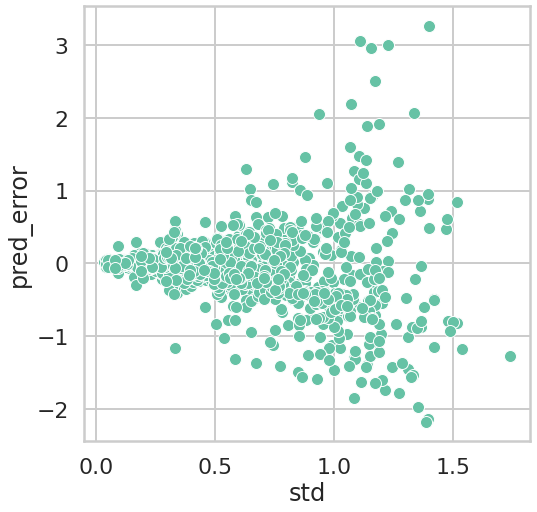

In [16]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
sns.scatterplot(data=pred_df, x="std", y="pred_error", ax=ax)

### Grid search
#### Tunable parameters for Random Forest models
- rf_estimators: number of estimators to use in random forest models
- rf_max_depth: the maximum depth of a decision tree in the random forest
- rf_max_features: max number of features to split random forest nodes

## Time for running the following code chunk: ~ 10 minutes on COLAB-Pro

In [17]:
# param_choice = [16,32,64,128]
param_choice = [16, 32, 64]

rfe_list = []
rfd_list = []
rff_list = []
valid_r2_list = []
for rf_estimator in param_choice:
    for rf_depth in param_choice:
        for rf_feature in param_choice:
            params["rf_estimators"] = rf_estimator
            params["rf_max_depth"] = rf_depth
            params["rf_max_features"] = rf_feature
            rfe_list.append(rf_estimator)
            rfd_list.append(rf_depth)
            rff_list.append(rf_feature)
            tp = parse.wrapper(params)
            pl = mp.ModelPipeline(tp)
            pl.train_model()
            pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
            pred_results = pred_data.get_prediction_results()
            valid_r2 = pred_results['r2_score']
            valid_r2_list.append(valid_r2)
            print(f"rf_estimators: {rf_estimator}, rf_max_depth: {rf_depth}, rf_max_features: {rf_feature}, valid_r2: {valid_r2}")

2021-09-18 16:32:20,454 Attempting to load featurized dataset
2021-09-18 16:32:20,463 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:32:20,464 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:32:20,475 Featurizing sample 0
2021-09-18 16:32:25,477 Featurizing sample 1000
2021-09-18 16:32:27,368 Previous dataset split restored
2021-09-18 16:32:27,385 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/d4b5209b-364b-4022-b010-31438af07e89/transformers.pkl
2021-09-18 16:32:27,386 Transforming response data
2021-09-18 16:32:27,415 Transforming response data
2021-09-18 16:32:27,431 Transforming response data
2021-09-18 16:32:27,461 Fitting random forest model


number of features: 1024


2021-09-18 16:32:27,913 Fold 0: training r2_score = 0.865, validation r2_score = 0.396, test r2_score = 0.431
2021-09-18 16:32:27,950 Wrote model tarball to ampl_output/H1_std_model_d4b5209b-364b-4022-b010-31438af07e89.tar.gz
2021-09-18 16:32:27,964 Attempting to load featurized dataset
2021-09-18 16:32:27,972 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:32:27,974 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:32:27,983 Featurizing sample 0


rf_estimators: 16, rf_max_depth: 16, rf_max_features: 16, valid_r2: 0.3960169267773953


2021-09-18 16:32:32,920 Featurizing sample 1000
2021-09-18 16:32:34,871 Previous dataset split restored
2021-09-18 16:32:34,887 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/05d6c5ee-2cca-48ce-ac94-05abaf7f992c/transformers.pkl
2021-09-18 16:32:34,890 Transforming response data
2021-09-18 16:32:34,916 Transforming response data
2021-09-18 16:32:34,930 Transforming response data
2021-09-18 16:32:34,960 Fitting random forest model


number of features: 1024


2021-09-18 16:32:35,413 Fold 0: training r2_score = 0.899, validation r2_score = 0.351, test r2_score = 0.502
2021-09-18 16:32:35,452 Wrote model tarball to ampl_output/H1_std_model_05d6c5ee-2cca-48ce-ac94-05abaf7f992c.tar.gz
2021-09-18 16:32:35,466 Attempting to load featurized dataset
2021-09-18 16:32:35,475 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:32:35,476 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:32:35,486 Featurizing sample 0


rf_estimators: 16, rf_max_depth: 16, rf_max_features: 32, valid_r2: 0.3505295881284277


2021-09-18 16:32:40,608 Featurizing sample 1000
2021-09-18 16:32:42,552 Previous dataset split restored
2021-09-18 16:32:42,569 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/a54aa9fc-a2d1-4ee1-967e-468447805588/transformers.pkl
2021-09-18 16:32:42,571 Transforming response data
2021-09-18 16:32:42,598 Transforming response data
2021-09-18 16:32:42,612 Transforming response data
2021-09-18 16:32:42,640 Fitting random forest model


number of features: 1024


2021-09-18 16:32:43,090 Fold 0: training r2_score = 0.915, validation r2_score = 0.460, test r2_score = 0.520
2021-09-18 16:32:43,130 Wrote model tarball to ampl_output/H1_std_model_a54aa9fc-a2d1-4ee1-967e-468447805588.tar.gz
2021-09-18 16:32:43,144 Attempting to load featurized dataset
2021-09-18 16:32:43,151 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:32:43,152 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:32:43,165 Featurizing sample 0


rf_estimators: 16, rf_max_depth: 16, rf_max_features: 64, valid_r2: 0.4600073638861877


2021-09-18 16:32:48,191 Featurizing sample 1000
2021-09-18 16:32:50,105 Previous dataset split restored
2021-09-18 16:32:50,124 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/15888261-1735-4984-b285-bac3dece668e/transformers.pkl
2021-09-18 16:32:50,125 Transforming response data
2021-09-18 16:32:50,151 Transforming response data
2021-09-18 16:32:50,165 Transforming response data
2021-09-18 16:32:50,194 Fitting random forest model


number of features: 1024


2021-09-18 16:32:50,644 Fold 0: training r2_score = 0.950, validation r2_score = 0.391, test r2_score = 0.501
2021-09-18 16:32:50,697 Wrote model tarball to ampl_output/H1_std_model_15888261-1735-4984-b285-bac3dece668e.tar.gz
2021-09-18 16:32:50,709 Attempting to load featurized dataset
2021-09-18 16:32:50,718 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:32:50,719 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:32:50,729 Featurizing sample 0


rf_estimators: 16, rf_max_depth: 32, rf_max_features: 16, valid_r2: 0.390933442289513


2021-09-18 16:32:55,723 Featurizing sample 1000
2021-09-18 16:32:57,681 Previous dataset split restored
2021-09-18 16:32:57,699 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/896b11ea-4989-49ff-9002-4350b0fbfa7e/transformers.pkl
2021-09-18 16:32:57,700 Transforming response data
2021-09-18 16:32:57,725 Transforming response data
2021-09-18 16:32:57,740 Transforming response data
2021-09-18 16:32:57,772 Fitting random forest model


number of features: 1024


2021-09-18 16:32:58,225 Fold 0: training r2_score = 0.953, validation r2_score = 0.439, test r2_score = 0.508
2021-09-18 16:32:58,279 Wrote model tarball to ampl_output/H1_std_model_896b11ea-4989-49ff-9002-4350b0fbfa7e.tar.gz
2021-09-18 16:32:58,291 Attempting to load featurized dataset
2021-09-18 16:32:58,300 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:32:58,302 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:32:58,312 Featurizing sample 0


rf_estimators: 16, rf_max_depth: 32, rf_max_features: 32, valid_r2: 0.4391800346215625


2021-09-18 16:33:03,289 Featurizing sample 1000
2021-09-18 16:33:05,169 Previous dataset split restored
2021-09-18 16:33:05,187 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/ea2ef382-78ef-4044-bf9c-3f349602179d/transformers.pkl
2021-09-18 16:33:05,188 Transforming response data
2021-09-18 16:33:05,213 Transforming response data
2021-09-18 16:33:05,227 Transforming response data
2021-09-18 16:33:05,255 Fitting random forest model


number of features: 1024


2021-09-18 16:33:05,704 Fold 0: training r2_score = 0.959, validation r2_score = 0.422, test r2_score = 0.458
2021-09-18 16:33:05,756 Wrote model tarball to ampl_output/H1_std_model_ea2ef382-78ef-4044-bf9c-3f349602179d.tar.gz
2021-09-18 16:33:05,769 Attempting to load featurized dataset
2021-09-18 16:33:05,777 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:33:05,779 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:33:05,789 Featurizing sample 0


rf_estimators: 16, rf_max_depth: 32, rf_max_features: 64, valid_r2: 0.42175707291938436


2021-09-18 16:33:10,776 Featurizing sample 1000
2021-09-18 16:33:12,732 Previous dataset split restored
2021-09-18 16:33:12,750 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/bf6c9935-ba64-40f4-a24a-3564588f9d96/transformers.pkl
2021-09-18 16:33:12,751 Transforming response data
2021-09-18 16:33:12,780 Transforming response data
2021-09-18 16:33:12,793 Transforming response data
2021-09-18 16:33:12,824 Fitting random forest model


number of features: 1024


2021-09-18 16:33:13,276 Fold 0: training r2_score = 0.955, validation r2_score = 0.352, test r2_score = 0.500
2021-09-18 16:33:13,330 Wrote model tarball to ampl_output/H1_std_model_bf6c9935-ba64-40f4-a24a-3564588f9d96.tar.gz
2021-09-18 16:33:13,342 Attempting to load featurized dataset
2021-09-18 16:33:13,351 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:33:13,352 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:33:13,362 Featurizing sample 0


rf_estimators: 16, rf_max_depth: 64, rf_max_features: 16, valid_r2: 0.35199459851153847


2021-09-18 16:33:18,437 Featurizing sample 1000
2021-09-18 16:33:20,389 Previous dataset split restored
2021-09-18 16:33:20,407 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/ca8dcd05-6616-4ecc-898d-aafb22732342/transformers.pkl
2021-09-18 16:33:20,408 Transforming response data
2021-09-18 16:33:20,434 Transforming response data
2021-09-18 16:33:20,448 Transforming response data
2021-09-18 16:33:20,480 Fitting random forest model


number of features: 1024


2021-09-18 16:33:20,931 Fold 0: training r2_score = 0.956, validation r2_score = 0.422, test r2_score = 0.482
2021-09-18 16:33:20,984 Wrote model tarball to ampl_output/H1_std_model_ca8dcd05-6616-4ecc-898d-aafb22732342.tar.gz
2021-09-18 16:33:20,998 Attempting to load featurized dataset
2021-09-18 16:33:21,007 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:33:21,009 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:33:21,019 Featurizing sample 0


rf_estimators: 16, rf_max_depth: 64, rf_max_features: 32, valid_r2: 0.4222441123695051


2021-09-18 16:33:25,950 Featurizing sample 1000
2021-09-18 16:33:27,814 Previous dataset split restored
2021-09-18 16:33:27,831 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/1ec0f9d1-9e0e-4c78-bedb-4e20f2bc900f/transformers.pkl
2021-09-18 16:33:27,833 Transforming response data
2021-09-18 16:33:27,861 Transforming response data
2021-09-18 16:33:27,875 Transforming response data
2021-09-18 16:33:27,905 Fitting random forest model


number of features: 1024


2021-09-18 16:33:28,357 Fold 0: training r2_score = 0.957, validation r2_score = 0.375, test r2_score = 0.498
2021-09-18 16:33:28,411 Wrote model tarball to ampl_output/H1_std_model_1ec0f9d1-9e0e-4c78-bedb-4e20f2bc900f.tar.gz
2021-09-18 16:33:28,423 Attempting to load featurized dataset
2021-09-18 16:33:28,432 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:33:28,433 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:33:28,444 Featurizing sample 0


rf_estimators: 16, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.3749356127735295


2021-09-18 16:33:33,521 Featurizing sample 1000
2021-09-18 16:33:35,468 Previous dataset split restored
2021-09-18 16:33:35,486 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/4096221f-8c88-4589-867c-ce6dad11fc9a/transformers.pkl
2021-09-18 16:33:35,487 Transforming response data
2021-09-18 16:33:35,515 Transforming response data
2021-09-18 16:33:35,529 Transforming response data
2021-09-18 16:33:35,559 Fitting random forest model


number of features: 1024


2021-09-18 16:33:36,017 Fold 0: training r2_score = 0.876, validation r2_score = 0.397, test r2_score = 0.450
2021-09-18 16:33:36,086 Wrote model tarball to ampl_output/H1_std_model_4096221f-8c88-4589-867c-ce6dad11fc9a.tar.gz
2021-09-18 16:33:36,102 Attempting to load featurized dataset
2021-09-18 16:33:36,112 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:33:36,114 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:33:36,126 Featurizing sample 0


rf_estimators: 32, rf_max_depth: 16, rf_max_features: 16, valid_r2: 0.39667846849909705


2021-09-18 16:33:41,229 Featurizing sample 1000
2021-09-18 16:33:43,152 Previous dataset split restored
2021-09-18 16:33:43,170 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/5ba1863f-f287-4611-81e8-51d4f0c0384c/transformers.pkl
2021-09-18 16:33:43,172 Transforming response data
2021-09-18 16:33:43,198 Transforming response data
2021-09-18 16:33:43,212 Transforming response data
2021-09-18 16:33:43,245 Fitting random forest model


number of features: 1024


2021-09-18 16:33:43,806 Fold 0: training r2_score = 0.903, validation r2_score = 0.393, test r2_score = 0.488
2021-09-18 16:33:43,874 Wrote model tarball to ampl_output/H1_std_model_5ba1863f-f287-4611-81e8-51d4f0c0384c.tar.gz
2021-09-18 16:33:43,886 Attempting to load featurized dataset
2021-09-18 16:33:43,894 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:33:43,896 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:33:43,907 Featurizing sample 0


rf_estimators: 32, rf_max_depth: 16, rf_max_features: 32, valid_r2: 0.3927811986768647


2021-09-18 16:33:48,879 Featurizing sample 1000
2021-09-18 16:33:50,804 Previous dataset split restored
2021-09-18 16:33:50,821 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/53989985-4f8a-4177-b398-97cec7ff6417/transformers.pkl
2021-09-18 16:33:50,823 Transforming response data
2021-09-18 16:33:50,850 Transforming response data
2021-09-18 16:33:50,865 Transforming response data


number of features: 1024


2021-09-18 16:33:50,900 Fitting random forest model
2021-09-18 16:33:51,464 Fold 0: training r2_score = 0.922, validation r2_score = 0.448, test r2_score = 0.527
2021-09-18 16:33:51,535 Wrote model tarball to ampl_output/H1_std_model_53989985-4f8a-4177-b398-97cec7ff6417.tar.gz
2021-09-18 16:33:51,548 Attempting to load featurized dataset
2021-09-18 16:33:51,556 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:33:51,557 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:33:51,569 Featurizing sample 0


rf_estimators: 32, rf_max_depth: 16, rf_max_features: 64, valid_r2: 0.4480686493700571


2021-09-18 16:33:56,636 Featurizing sample 1000
2021-09-18 16:33:58,582 Previous dataset split restored
2021-09-18 16:33:58,601 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/efcc4990-d06e-451a-a7f4-a1acad2b6b2d/transformers.pkl
2021-09-18 16:33:58,602 Transforming response data
2021-09-18 16:33:58,631 Transforming response data
2021-09-18 16:33:58,645 Transforming response data


number of features: 1024


2021-09-18 16:33:58,678 Fitting random forest model
2021-09-18 16:33:59,245 Fold 0: training r2_score = 0.959, validation r2_score = 0.426, test r2_score = 0.486
2021-09-18 16:33:59,344 Wrote model tarball to ampl_output/H1_std_model_efcc4990-d06e-451a-a7f4-a1acad2b6b2d.tar.gz
2021-09-18 16:33:59,364 Attempting to load featurized dataset
2021-09-18 16:33:59,374 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:33:59,376 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:33:59,393 Featurizing sample 0


rf_estimators: 32, rf_max_depth: 32, rf_max_features: 16, valid_r2: 0.4262498577011963


2021-09-18 16:34:04,344 Featurizing sample 1000
2021-09-18 16:34:06,270 Previous dataset split restored
2021-09-18 16:34:06,289 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/48c854cb-60c6-4f5a-9108-4932bef62834/transformers.pkl
2021-09-18 16:34:06,290 Transforming response data
2021-09-18 16:34:06,317 Transforming response data
2021-09-18 16:34:06,332 Transforming response data
2021-09-18 16:34:06,361 Fitting random forest model


number of features: 1024


2021-09-18 16:34:06,920 Fold 0: training r2_score = 0.960, validation r2_score = 0.433, test r2_score = 0.480
2021-09-18 16:34:07,016 Wrote model tarball to ampl_output/H1_std_model_48c854cb-60c6-4f5a-9108-4932bef62834.tar.gz
2021-09-18 16:34:07,031 Attempting to load featurized dataset
2021-09-18 16:34:07,040 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:34:07,042 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:34:07,053 Featurizing sample 0


rf_estimators: 32, rf_max_depth: 32, rf_max_features: 32, valid_r2: 0.43324663147638043


2021-09-18 16:34:12,151 Featurizing sample 1000
2021-09-18 16:34:14,199 Previous dataset split restored
2021-09-18 16:34:14,216 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/176a6067-f1a8-47b1-a201-703afedfea5d/transformers.pkl
2021-09-18 16:34:14,218 Transforming response data
2021-09-18 16:34:14,244 Transforming response data
2021-09-18 16:34:14,258 Transforming response data
2021-09-18 16:34:14,289 Fitting random forest model


number of features: 1024


2021-09-18 16:34:14,845 Fold 0: training r2_score = 0.961, validation r2_score = 0.421, test r2_score = 0.475
2021-09-18 16:34:14,945 Wrote model tarball to ampl_output/H1_std_model_176a6067-f1a8-47b1-a201-703afedfea5d.tar.gz
2021-09-18 16:34:14,960 Attempting to load featurized dataset
2021-09-18 16:34:14,969 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:34:14,971 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:34:14,983 Featurizing sample 0


rf_estimators: 32, rf_max_depth: 32, rf_max_features: 64, valid_r2: 0.42073470264383217


2021-09-18 16:34:20,055 Featurizing sample 1000
2021-09-18 16:34:21,948 Previous dataset split restored
2021-09-18 16:34:21,964 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/a38d7b18-4969-4955-8e1f-c8f1fb3054be/transformers.pkl
2021-09-18 16:34:21,965 Transforming response data
2021-09-18 16:34:21,992 Transforming response data
2021-09-18 16:34:22,006 Transforming response data
2021-09-18 16:34:22,038 Fitting random forest model


number of features: 1024


2021-09-18 16:34:22,599 Fold 0: training r2_score = 0.961, validation r2_score = 0.399, test r2_score = 0.530
2021-09-18 16:34:22,700 Wrote model tarball to ampl_output/H1_std_model_a38d7b18-4969-4955-8e1f-c8f1fb3054be.tar.gz
2021-09-18 16:34:22,713 Attempting to load featurized dataset
2021-09-18 16:34:22,721 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:34:22,722 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:34:22,733 Featurizing sample 0


rf_estimators: 32, rf_max_depth: 64, rf_max_features: 16, valid_r2: 0.3988567012433486


2021-09-18 16:34:27,711 Featurizing sample 1000
2021-09-18 16:34:29,594 Previous dataset split restored
2021-09-18 16:34:29,611 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/27361b4b-710e-4202-a702-366c0bfd84db/transformers.pkl
2021-09-18 16:34:29,613 Transforming response data
2021-09-18 16:34:29,639 Transforming response data
2021-09-18 16:34:29,654 Transforming response data
2021-09-18 16:34:29,684 Fitting random forest model


number of features: 1024


2021-09-18 16:34:30,243 Fold 0: training r2_score = 0.961, validation r2_score = 0.436, test r2_score = 0.528
2021-09-18 16:34:30,343 Wrote model tarball to ampl_output/H1_std_model_27361b4b-710e-4202-a702-366c0bfd84db.tar.gz
2021-09-18 16:34:30,357 Attempting to load featurized dataset
2021-09-18 16:34:30,366 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:34:30,368 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:34:30,381 Featurizing sample 0


rf_estimators: 32, rf_max_depth: 64, rf_max_features: 32, valid_r2: 0.43641026586067666


2021-09-18 16:34:35,458 Featurizing sample 1000
2021-09-18 16:34:37,382 Previous dataset split restored
2021-09-18 16:34:37,399 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/6481dfd4-2eeb-4d60-937f-5c1497c24319/transformers.pkl
2021-09-18 16:34:37,400 Transforming response data
2021-09-18 16:34:37,425 Transforming response data
2021-09-18 16:34:37,439 Transforming response data
2021-09-18 16:34:37,467 Fitting random forest model


number of features: 1024


2021-09-18 16:34:38,025 Fold 0: training r2_score = 0.965, validation r2_score = 0.468, test r2_score = 0.532
2021-09-18 16:34:38,127 Wrote model tarball to ampl_output/H1_std_model_6481dfd4-2eeb-4d60-937f-5c1497c24319.tar.gz
2021-09-18 16:34:38,142 Attempting to load featurized dataset
2021-09-18 16:34:38,151 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:34:38,152 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:34:38,165 Featurizing sample 0


rf_estimators: 32, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.46793790088782805


2021-09-18 16:34:43,119 Featurizing sample 1000
2021-09-18 16:34:45,004 Previous dataset split restored
2021-09-18 16:34:45,025 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/5fbf8680-454e-4b7b-9f36-1f192dbd1c1a/transformers.pkl
2021-09-18 16:34:45,026 Transforming response data
2021-09-18 16:34:45,054 Transforming response data
2021-09-18 16:34:45,069 Transforming response data


number of features: 1024


2021-09-18 16:34:45,107 Fitting random forest model
2021-09-18 16:34:45,677 Fold 0: training r2_score = 0.878, validation r2_score = 0.348, test r2_score = 0.447
2021-09-18 16:34:45,805 Wrote model tarball to ampl_output/H1_std_model_5fbf8680-454e-4b7b-9f36-1f192dbd1c1a.tar.gz
2021-09-18 16:34:45,820 Attempting to load featurized dataset
2021-09-18 16:34:45,830 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:34:45,831 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:34:45,842 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 16, rf_max_features: 16, valid_r2: 0.34791149503882035


2021-09-18 16:34:50,896 Featurizing sample 1000
2021-09-18 16:34:52,868 Previous dataset split restored
2021-09-18 16:34:52,886 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/d848cc25-fb45-45e9-b2de-68ce9a069b86/transformers.pkl
2021-09-18 16:34:52,887 Transforming response data
2021-09-18 16:34:52,913 Transforming response data
2021-09-18 16:34:52,927 Transforming response data
2021-09-18 16:34:52,960 Fitting random forest model


number of features: 1024


2021-09-18 16:34:53,635 Fold 0: training r2_score = 0.908, validation r2_score = 0.402, test r2_score = 0.479
2021-09-18 16:34:53,763 Wrote model tarball to ampl_output/H1_std_model_d848cc25-fb45-45e9-b2de-68ce9a069b86.tar.gz
2021-09-18 16:34:53,776 Attempting to load featurized dataset
2021-09-18 16:34:53,784 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:34:53,786 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:34:53,797 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 16, rf_max_features: 32, valid_r2: 0.4019794255947188


2021-09-18 16:34:58,851 Featurizing sample 1000
2021-09-18 16:35:00,747 Previous dataset split restored
2021-09-18 16:35:00,765 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/69e0e17c-a5a8-4409-8bae-a13620285666/transformers.pkl
2021-09-18 16:35:00,767 Transforming response data
2021-09-18 16:35:00,794 Transforming response data
2021-09-18 16:35:00,810 Transforming response data


number of features: 1024


2021-09-18 16:35:00,846 Fitting random forest model
2021-09-18 16:35:01,516 Fold 0: training r2_score = 0.923, validation r2_score = 0.429, test r2_score = 0.529
2021-09-18 16:35:01,648 Wrote model tarball to ampl_output/H1_std_model_69e0e17c-a5a8-4409-8bae-a13620285666.tar.gz
2021-09-18 16:35:01,666 Attempting to load featurized dataset
2021-09-18 16:35:01,675 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:35:01,676 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:35:01,688 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 16, rf_max_features: 64, valid_r2: 0.429235118555676


2021-09-18 16:35:06,615 Featurizing sample 1000
2021-09-18 16:35:08,509 Previous dataset split restored
2021-09-18 16:35:08,527 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/3e578b96-ce55-4b21-8a84-7e5c69743287/transformers.pkl
2021-09-18 16:35:08,528 Transforming response data
2021-09-18 16:35:08,557 Transforming response data
2021-09-18 16:35:08,572 Transforming response data


number of features: 1024


2021-09-18 16:35:08,604 Fitting random forest model
2021-09-18 16:35:09,281 Fold 0: training r2_score = 0.960, validation r2_score = 0.423, test r2_score = 0.502
2021-09-18 16:35:09,466 Wrote model tarball to ampl_output/H1_std_model_3e578b96-ce55-4b21-8a84-7e5c69743287.tar.gz
2021-09-18 16:35:09,480 Attempting to load featurized dataset
2021-09-18 16:35:09,488 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:35:09,489 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:35:09,500 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 32, rf_max_features: 16, valid_r2: 0.4230715585256083


2021-09-18 16:35:14,621 Featurizing sample 1000
2021-09-18 16:35:16,573 Previous dataset split restored
2021-09-18 16:35:16,592 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/d29f228b-4da7-4f52-9b74-7113e55727c9/transformers.pkl
2021-09-18 16:35:16,594 Transforming response data
2021-09-18 16:35:16,622 Transforming response data
2021-09-18 16:35:16,636 Transforming response data


number of features: 1024


2021-09-18 16:35:16,670 Fitting random forest model
2021-09-18 16:35:17,347 Fold 0: training r2_score = 0.962, validation r2_score = 0.433, test r2_score = 0.510
2021-09-18 16:35:17,529 Wrote model tarball to ampl_output/H1_std_model_d29f228b-4da7-4f52-9b74-7113e55727c9.tar.gz
2021-09-18 16:35:17,544 Attempting to load featurized dataset
2021-09-18 16:35:17,552 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:35:17,554 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:35:17,565 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 32, rf_max_features: 32, valid_r2: 0.4325768493441816


2021-09-18 16:35:22,601 Featurizing sample 1000
2021-09-18 16:35:24,489 Previous dataset split restored
2021-09-18 16:35:24,504 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/2ae19a92-9511-4ed6-b39e-2e44e5940dce/transformers.pkl
2021-09-18 16:35:24,506 Transforming response data
2021-09-18 16:35:24,532 Transforming response data
2021-09-18 16:35:24,546 Transforming response data
2021-09-18 16:35:24,574 Fitting random forest model


number of features: 1024


2021-09-18 16:35:25,245 Fold 0: training r2_score = 0.963, validation r2_score = 0.437, test r2_score = 0.533
2021-09-18 16:35:25,429 Wrote model tarball to ampl_output/H1_std_model_2ae19a92-9511-4ed6-b39e-2e44e5940dce.tar.gz
2021-09-18 16:35:25,445 Attempting to load featurized dataset
2021-09-18 16:35:25,454 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:35:25,456 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:35:25,468 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 32, rf_max_features: 64, valid_r2: 0.4371304243058133


2021-09-18 16:35:30,509 Featurizing sample 1000
2021-09-18 16:35:32,461 Previous dataset split restored
2021-09-18 16:35:32,477 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/cfb5f335-b7cd-45a1-bc22-8061b0d64438/transformers.pkl
2021-09-18 16:35:32,479 Transforming response data
2021-09-18 16:35:32,507 Transforming response data
2021-09-18 16:35:32,521 Transforming response data


number of features: 1024


2021-09-18 16:35:32,555 Fitting random forest model
2021-09-18 16:35:33,230 Fold 0: training r2_score = 0.963, validation r2_score = 0.422, test r2_score = 0.526
2021-09-18 16:35:33,425 Wrote model tarball to ampl_output/H1_std_model_cfb5f335-b7cd-45a1-bc22-8061b0d64438.tar.gz
2021-09-18 16:35:33,441 Attempting to load featurized dataset
2021-09-18 16:35:33,451 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:35:33,453 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:35:33,464 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 16, valid_r2: 0.42164000670865054


2021-09-18 16:35:38,555 Featurizing sample 1000
2021-09-18 16:35:40,446 Previous dataset split restored
2021-09-18 16:35:40,465 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/3d65db66-31d6-4542-81ce-c0d01540f055/transformers.pkl
2021-09-18 16:35:40,466 Transforming response data
2021-09-18 16:35:40,492 Transforming response data
2021-09-18 16:35:40,506 Transforming response data
2021-09-18 16:35:40,536 Fitting random forest model


number of features: 1024


2021-09-18 16:35:41,208 Fold 0: training r2_score = 0.964, validation r2_score = 0.445, test r2_score = 0.523
2021-09-18 16:35:41,400 Wrote model tarball to ampl_output/H1_std_model_3d65db66-31d6-4542-81ce-c0d01540f055.tar.gz
2021-09-18 16:35:41,417 Attempting to load featurized dataset
2021-09-18 16:35:41,427 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:35:41,428 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:35:41,439 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 32, valid_r2: 0.4449688806778509


2021-09-18 16:35:46,439 Featurizing sample 1000
2021-09-18 16:35:48,366 Previous dataset split restored
2021-09-18 16:35:48,386 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/46f25ee9-77f3-4e35-b22f-a924ce13a39a/transformers.pkl
2021-09-18 16:35:48,388 Transforming response data
2021-09-18 16:35:48,416 Transforming response data
2021-09-18 16:35:48,430 Transforming response data


number of features: 1024


2021-09-18 16:35:48,463 Fitting random forest model
2021-09-18 16:35:49,238 Fold 0: training r2_score = 0.964, validation r2_score = 0.436, test r2_score = 0.529
2021-09-18 16:35:49,430 Wrote model tarball to ampl_output/H1_std_model_46f25ee9-77f3-4e35-b22f-a924ce13a39a.tar.gz


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4359956045728688


In [18]:
perf_df = pd.DataFrame({"rf_estimators": rfe_list, "rf_max_depth": rfd_list, "rf_max_features": rff_list, "valid_r2_score": valid_r2_list})
perf_df.sort_values(by="valid_r2_score", ascending=False)

,rf_estimators,rf_max_depth,rf_max_features,valid_r2_score
17,32,64,64,0.467938
2,16,16,64,0.460007
11,32,16,64,0.448069
25,64,64,32,0.444969
4,16,32,32,0.439180
23,64,32,64,0.437130
16,32,64,32,0.436410
26,64,64,64,0.435996
13,32,32,32,0.433247
22,64,32,32,0.432577


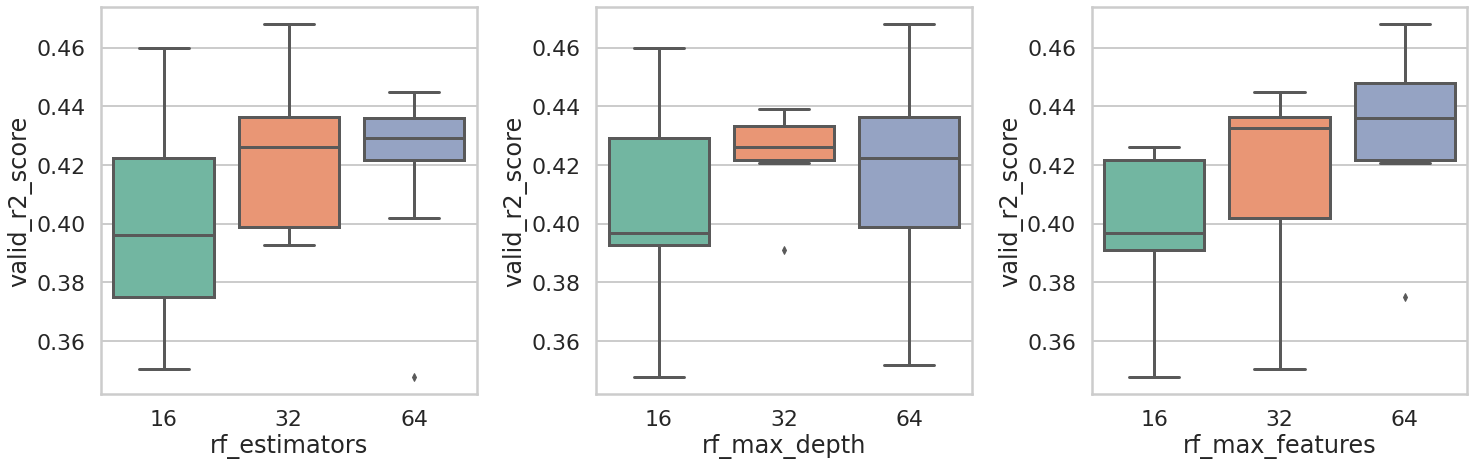

In [19]:
fig, ax = plt.subplots(1,3,figsize=(21,7))
sns.boxplot(data=perf_df, x="rf_estimators", y="valid_r2_score", ax=ax[0])
sns.boxplot(data=perf_df, x="rf_max_depth", y="valid_r2_score", ax=ax[1])
sns.boxplot(data=perf_df, x="rf_max_features", y="valid_r2_score", ax=ax[2])
fig.tight_layout()

## Time for running the following code chunk: ~ 10 minutes on COLAB-Pro

### Random search

In [20]:
rfe_list = []
rfd_list = []
rff_list = []
valid_r2_list = []

num_trials = 50

for i in range(num_trials):
    params["rf_estimators"] = np.random.randint(8,256)
    params["rf_max_depth"] = np.random.randint(8,256)
    params["rf_max_features"] = np.random.randint(8,256)
    rfe_list.append(params["rf_estimators"])
    rfd_list.append(params["rf_max_depth"])
    rff_list.append(params["rf_max_features"])
    tp = parse.wrapper(params)
    pl = mp.ModelPipeline(tp)
    pl.train_model()
    pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
    pred_results = pred_data.get_prediction_results()
    valid_r2 = pred_results['r2_score']
    valid_r2_list.append(valid_r2)
    print(f"rf_estimators: {rf_estimator}, rf_max_depth: {rf_depth}, rf_max_features: {rf_feature}, valid_r2: {valid_r2}")

2021-09-18 16:35:50,339 Attempting to load featurized dataset
2021-09-18 16:35:50,349 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:35:50,351 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:35:50,365 Featurizing sample 0
2021-09-18 16:35:55,635 Featurizing sample 1000
2021-09-18 16:35:57,562 Previous dataset split restored
2021-09-18 16:35:57,581 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/d364621c-ef1e-4cc4-aed7-3c86da0752ea/transformers.pkl
2021-09-18 16:35:57,583 Transforming response data
2021-09-18 16:35:57,609 Transforming response data
2021-09-18 16:35:57,623 Transforming response data
2021-09-18 16:35:57,653 Fitting random forest model


number of features: 1024


2021-09-18 16:35:58,643 Fold 0: training r2_score = 0.966, validation r2_score = 0.459, test r2_score = 0.539
2021-09-18 16:35:58,970 Wrote model tarball to ampl_output/H1_std_model_d364621c-ef1e-4cc4-aed7-3c86da0752ea.tar.gz
2021-09-18 16:35:58,986 Attempting to load featurized dataset
2021-09-18 16:35:58,995 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:35:58,996 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:35:59,008 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.45875868345740045


2021-09-18 16:36:03,933 Featurizing sample 1000
2021-09-18 16:36:05,837 Previous dataset split restored
2021-09-18 16:36:05,853 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/648d1a42-614b-4a18-93ff-429c737816a6/transformers.pkl
2021-09-18 16:36:05,856 Transforming response data
2021-09-18 16:36:05,883 Transforming response data
2021-09-18 16:36:05,897 Transforming response data
2021-09-18 16:36:05,926 Fitting random forest model


number of features: 1024


2021-09-18 16:36:07,125 Fold 0: training r2_score = 0.966, validation r2_score = 0.438, test r2_score = 0.531
2021-09-18 16:36:07,462 Wrote model tarball to ampl_output/H1_std_model_648d1a42-614b-4a18-93ff-429c737816a6.tar.gz
2021-09-18 16:36:07,476 Attempting to load featurized dataset
2021-09-18 16:36:07,484 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:36:07,485 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:36:07,496 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.43762827525482717


2021-09-18 16:36:12,625 Featurizing sample 1000
2021-09-18 16:36:14,571 Previous dataset split restored
2021-09-18 16:36:14,589 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/f448c5e4-ee1c-4e68-9943-2d675ae3acb8/transformers.pkl
2021-09-18 16:36:14,590 Transforming response data
2021-09-18 16:36:14,616 Transforming response data
2021-09-18 16:36:14,631 Transforming response data
2021-09-18 16:36:14,661 Fitting random forest model


number of features: 1024


2021-09-18 16:36:15,853 Fold 0: training r2_score = 0.966, validation r2_score = 0.464, test r2_score = 0.511
2021-09-18 16:36:16,187 Wrote model tarball to ampl_output/H1_std_model_f448c5e4-ee1c-4e68-9943-2d675ae3acb8.tar.gz
2021-09-18 16:36:16,200 Attempting to load featurized dataset
2021-09-18 16:36:16,209 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:36:16,210 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:36:16,221 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.46441668064531505


2021-09-18 16:36:21,157 Featurizing sample 1000
2021-09-18 16:36:23,024 Previous dataset split restored
2021-09-18 16:36:23,041 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/86a70822-0a9f-4553-b5ed-00a0ebb6845f/transformers.pkl
2021-09-18 16:36:23,042 Transforming response data
2021-09-18 16:36:23,070 Transforming response data
2021-09-18 16:36:23,084 Transforming response data
2021-09-18 16:36:23,114 Fitting random forest model


number of features: 1024


2021-09-18 16:36:24,958 Fold 0: training r2_score = 0.966, validation r2_score = 0.454, test r2_score = 0.549
2021-09-18 16:36:25,673 Wrote model tarball to ampl_output/H1_std_model_86a70822-0a9f-4553-b5ed-00a0ebb6845f.tar.gz
2021-09-18 16:36:25,689 Attempting to load featurized dataset
2021-09-18 16:36:25,698 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:36:25,700 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:36:25,712 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.45441029873539696


2021-09-18 16:36:30,697 Featurizing sample 1000
2021-09-18 16:36:32,627 Previous dataset split restored
2021-09-18 16:36:32,647 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/2fb5d465-37b1-4d15-9209-d245cf39a079/transformers.pkl
2021-09-18 16:36:32,648 Transforming response data
2021-09-18 16:36:32,675 Transforming response data
2021-09-18 16:36:32,690 Transforming response data


number of features: 1024


2021-09-18 16:36:32,723 Fitting random forest model
2021-09-18 16:36:33,722 Fold 0: training r2_score = 0.964, validation r2_score = 0.440, test r2_score = 0.540
2021-09-18 16:36:34,093 Wrote model tarball to ampl_output/H1_std_model_2fb5d465-37b1-4d15-9209-d245cf39a079.tar.gz
2021-09-18 16:36:34,114 Attempting to load featurized dataset
2021-09-18 16:36:34,123 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:36:34,125 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:36:34,138 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.43956170904649194


2021-09-18 16:36:39,146 Featurizing sample 1000
2021-09-18 16:36:41,034 Previous dataset split restored
2021-09-18 16:36:41,051 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/b1539d46-7cc0-41d7-b5de-ee272fb4abf3/transformers.pkl
2021-09-18 16:36:41,053 Transforming response data
2021-09-18 16:36:41,080 Transforming response data
2021-09-18 16:36:41,095 Transforming response data
2021-09-18 16:36:41,124 Fitting random forest model


number of features: 1024


2021-09-18 16:36:42,658 Fold 0: training r2_score = 0.966, validation r2_score = 0.469, test r2_score = 0.530
2021-09-18 16:36:43,246 Wrote model tarball to ampl_output/H1_std_model_b1539d46-7cc0-41d7-b5de-ee272fb4abf3.tar.gz
2021-09-18 16:36:43,262 Attempting to load featurized dataset
2021-09-18 16:36:43,272 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:36:43,273 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:36:43,284 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.46854381635706865


2021-09-18 16:36:48,342 Featurizing sample 1000
2021-09-18 16:36:50,311 Previous dataset split restored
2021-09-18 16:36:50,329 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/84bf891f-a23e-4ced-8253-f04a41a8003b/transformers.pkl
2021-09-18 16:36:50,331 Transforming response data
2021-09-18 16:36:50,357 Transforming response data
2021-09-18 16:36:50,371 Transforming response data
2021-09-18 16:36:50,401 Fitting random forest model


number of features: 1024


2021-09-18 16:36:51,488 Fold 0: training r2_score = 0.962, validation r2_score = 0.462, test r2_score = 0.534
2021-09-18 16:36:51,744 Wrote model tarball to ampl_output/H1_std_model_84bf891f-a23e-4ced-8253-f04a41a8003b.tar.gz
2021-09-18 16:36:51,760 Attempting to load featurized dataset
2021-09-18 16:36:51,768 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:36:51,770 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:36:51,782 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4622962571208523


2021-09-18 16:36:56,829 Featurizing sample 1000
2021-09-18 16:36:58,722 Previous dataset split restored
2021-09-18 16:36:58,738 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/002eedd3-9398-4cca-946c-c086c6020886/transformers.pkl
2021-09-18 16:36:58,740 Transforming response data
2021-09-18 16:36:58,768 Transforming response data
2021-09-18 16:36:58,783 Transforming response data
2021-09-18 16:36:58,812 Fitting random forest model


number of features: 1024


2021-09-18 16:37:00,099 Fold 0: training r2_score = 0.965, validation r2_score = 0.453, test r2_score = 0.526
2021-09-18 16:37:00,402 Wrote model tarball to ampl_output/H1_std_model_002eedd3-9398-4cca-946c-c086c6020886.tar.gz
2021-09-18 16:37:00,415 Attempting to load featurized dataset
2021-09-18 16:37:00,424 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:37:00,425 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:37:00,436 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.45343288994104436


2021-09-18 16:37:05,361 Featurizing sample 1000
2021-09-18 16:37:07,298 Previous dataset split restored
2021-09-18 16:37:07,315 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/4e657128-a165-4bf9-bfc7-7826fccf0d3a/transformers.pkl
2021-09-18 16:37:07,317 Transforming response data
2021-09-18 16:37:07,346 Transforming response data
2021-09-18 16:37:07,360 Transforming response data
2021-09-18 16:37:07,390 Fitting random forest model


number of features: 1024


2021-09-18 16:37:08,592 Fold 0: training r2_score = 0.965, validation r2_score = 0.452, test r2_score = 0.547
2021-09-18 16:37:08,957 Wrote model tarball to ampl_output/H1_std_model_4e657128-a165-4bf9-bfc7-7826fccf0d3a.tar.gz
2021-09-18 16:37:08,970 Attempting to load featurized dataset
2021-09-18 16:37:08,979 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:37:08,980 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:37:08,991 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.45200906915440886


2021-09-18 16:37:14,092 Featurizing sample 1000
2021-09-18 16:37:15,998 Previous dataset split restored
2021-09-18 16:37:16,015 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/0448199f-979d-4989-ae28-1d673ae8bc46/transformers.pkl
2021-09-18 16:37:16,016 Transforming response data
2021-09-18 16:37:16,041 Transforming response data
2021-09-18 16:37:16,056 Transforming response data
2021-09-18 16:37:16,085 Fitting random forest model


number of features: 1024


2021-09-18 16:37:17,809 Fold 0: training r2_score = 0.967, validation r2_score = 0.443, test r2_score = 0.544
2021-09-18 16:37:18,376 Wrote model tarball to ampl_output/H1_std_model_0448199f-979d-4989-ae28-1d673ae8bc46.tar.gz
2021-09-18 16:37:18,390 Attempting to load featurized dataset
2021-09-18 16:37:18,398 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:37:18,400 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:37:18,410 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4428802685208172


2021-09-18 16:37:23,351 Featurizing sample 1000
2021-09-18 16:37:25,243 Previous dataset split restored
2021-09-18 16:37:25,260 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/2c7f8bb7-e68c-4f01-9bf2-e59d7458644b/transformers.pkl
2021-09-18 16:37:25,261 Transforming response data
2021-09-18 16:37:25,287 Transforming response data
2021-09-18 16:37:25,302 Transforming response data
2021-09-18 16:37:25,333 Fitting random forest model


number of features: 1024


2021-09-18 16:37:26,770 Fold 0: training r2_score = 0.966, validation r2_score = 0.445, test r2_score = 0.531
2021-09-18 16:37:27,452 Wrote model tarball to ampl_output/H1_std_model_2c7f8bb7-e68c-4f01-9bf2-e59d7458644b.tar.gz
2021-09-18 16:37:27,469 Attempting to load featurized dataset
2021-09-18 16:37:27,478 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:37:27,479 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:37:27,490 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.44531781338033827


2021-09-18 16:37:32,589 Featurizing sample 1000
2021-09-18 16:37:34,511 Previous dataset split restored
2021-09-18 16:37:34,528 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/af00f727-0805-4d6f-a630-0ed278698e89/transformers.pkl
2021-09-18 16:37:34,530 Transforming response data
2021-09-18 16:37:34,555 Transforming response data
2021-09-18 16:37:34,569 Transforming response data
2021-09-18 16:37:34,599 Fitting random forest model


number of features: 1024


2021-09-18 16:37:35,680 Fold 0: training r2_score = 0.966, validation r2_score = 0.442, test r2_score = 0.549
2021-09-18 16:37:35,938 Wrote model tarball to ampl_output/H1_std_model_af00f727-0805-4d6f-a630-0ed278698e89.tar.gz
2021-09-18 16:37:35,953 Attempting to load featurized dataset
2021-09-18 16:37:35,962 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:37:35,963 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:37:35,973 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.44184619128314084


2021-09-18 16:37:40,889 Featurizing sample 1000
2021-09-18 16:37:42,783 Previous dataset split restored
2021-09-18 16:37:42,799 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/61e06822-08c0-4afb-b090-f794b32ad5cb/transformers.pkl
2021-09-18 16:37:42,800 Transforming response data
2021-09-18 16:37:42,826 Transforming response data
2021-09-18 16:37:42,840 Transforming response data
2021-09-18 16:37:42,869 Fitting random forest model


number of features: 1024


2021-09-18 16:37:44,205 Fold 0: training r2_score = 0.966, validation r2_score = 0.457, test r2_score = 0.534
2021-09-18 16:37:44,862 Wrote model tarball to ampl_output/H1_std_model_61e06822-08c0-4afb-b090-f794b32ad5cb.tar.gz
2021-09-18 16:37:44,877 Attempting to load featurized dataset
2021-09-18 16:37:44,886 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:37:44,887 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:37:44,900 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4568924462647712


2021-09-18 16:37:50,019 Featurizing sample 1000
2021-09-18 16:37:51,969 Previous dataset split restored
2021-09-18 16:37:51,986 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/6d359a29-f368-44ac-8fff-9bd2ea976158/transformers.pkl
2021-09-18 16:37:51,988 Transforming response data
2021-09-18 16:37:52,013 Transforming response data
2021-09-18 16:37:52,029 Transforming response data
2021-09-18 16:37:52,059 Fitting random forest model


number of features: 1024


2021-09-18 16:37:53,587 Fold 0: training r2_score = 0.933, validation r2_score = 0.454, test r2_score = 0.532
2021-09-18 16:37:53,965 Wrote model tarball to ampl_output/H1_std_model_6d359a29-f368-44ac-8fff-9bd2ea976158.tar.gz
2021-09-18 16:37:53,982 Attempting to load featurized dataset
2021-09-18 16:37:53,990 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:37:53,992 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:37:54,003 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4539818763069313


2021-09-18 16:37:58,982 Featurizing sample 1000
2021-09-18 16:38:00,919 Previous dataset split restored
2021-09-18 16:38:00,935 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/6deeacf6-cb89-4196-b939-03c88001c8e5/transformers.pkl
2021-09-18 16:38:00,936 Transforming response data
2021-09-18 16:38:00,962 Transforming response data
2021-09-18 16:38:00,977 Transforming response data
2021-09-18 16:38:01,006 Fitting random forest model


number of features: 1024


2021-09-18 16:38:02,938 Fold 0: training r2_score = 0.966, validation r2_score = 0.472, test r2_score = 0.534
2021-09-18 16:38:03,541 Wrote model tarball to ampl_output/H1_std_model_6deeacf6-cb89-4196-b939-03c88001c8e5.tar.gz
2021-09-18 16:38:03,558 Attempting to load featurized dataset
2021-09-18 16:38:03,567 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:38:03,568 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:38:03,580 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4719336501463919


2021-09-18 16:38:08,669 Featurizing sample 1000
2021-09-18 16:38:10,644 Previous dataset split restored
2021-09-18 16:38:10,661 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/9bc4e486-4ab3-4bf1-9bdc-9bb66ce8d5fd/transformers.pkl
2021-09-18 16:38:10,662 Transforming response data
2021-09-18 16:38:10,690 Transforming response data
2021-09-18 16:38:10,703 Transforming response data
2021-09-18 16:38:10,733 Fitting random forest model


number of features: 1024


2021-09-18 16:38:11,754 Fold 0: training r2_score = 0.964, validation r2_score = 0.408, test r2_score = 0.501
2021-09-18 16:38:12,252 Wrote model tarball to ampl_output/H1_std_model_9bc4e486-4ab3-4bf1-9bdc-9bb66ce8d5fd.tar.gz
2021-09-18 16:38:12,267 Attempting to load featurized dataset
2021-09-18 16:38:12,275 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:38:12,277 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:38:12,287 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.408333826636768


2021-09-18 16:38:17,271 Featurizing sample 1000
2021-09-18 16:38:19,185 Previous dataset split restored
2021-09-18 16:38:19,203 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/75bb1153-fa58-4a3b-941e-126e93454a30/transformers.pkl
2021-09-18 16:38:19,204 Transforming response data
2021-09-18 16:38:19,228 Transforming response data
2021-09-18 16:38:19,241 Transforming response data
2021-09-18 16:38:19,270 Fitting random forest model


number of features: 1024


2021-09-18 16:38:20,799 Fold 0: training r2_score = 0.966, validation r2_score = 0.454, test r2_score = 0.535
2021-09-18 16:38:21,415 Wrote model tarball to ampl_output/H1_std_model_75bb1153-fa58-4a3b-941e-126e93454a30.tar.gz
2021-09-18 16:38:21,431 Attempting to load featurized dataset
2021-09-18 16:38:21,440 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:38:21,441 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:38:21,452 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.45353626979125294


2021-09-18 16:38:26,508 Featurizing sample 1000
2021-09-18 16:38:28,458 Previous dataset split restored
2021-09-18 16:38:28,475 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/b2e3e63b-8802-4ceb-881b-5387e0f2c292/transformers.pkl
2021-09-18 16:38:28,477 Transforming response data
2021-09-18 16:38:28,502 Transforming response data
2021-09-18 16:38:28,516 Transforming response data
2021-09-18 16:38:28,546 Fitting random forest model


number of features: 1024


2021-09-18 16:38:29,310 Fold 0: training r2_score = 0.965, validation r2_score = 0.432, test r2_score = 0.519
2021-09-18 16:38:29,450 Wrote model tarball to ampl_output/H1_std_model_b2e3e63b-8802-4ceb-881b-5387e0f2c292.tar.gz
2021-09-18 16:38:29,463 Attempting to load featurized dataset
2021-09-18 16:38:29,472 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:38:29,473 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:38:29,484 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.43229624241133613


2021-09-18 16:38:34,505 Featurizing sample 1000
2021-09-18 16:38:36,430 Previous dataset split restored
2021-09-18 16:38:36,446 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/a5c2efb1-e710-4baf-b4bb-04a0a013e85c/transformers.pkl
2021-09-18 16:38:36,448 Transforming response data
2021-09-18 16:38:36,472 Transforming response data
2021-09-18 16:38:36,486 Transforming response data
2021-09-18 16:38:36,514 Fitting random forest model


number of features: 1024


2021-09-18 16:38:37,509 Fold 0: training r2_score = 0.965, validation r2_score = 0.450, test r2_score = 0.544
2021-09-18 16:38:37,883 Wrote model tarball to ampl_output/H1_std_model_a5c2efb1-e710-4baf-b4bb-04a0a013e85c.tar.gz
2021-09-18 16:38:37,898 Attempting to load featurized dataset
2021-09-18 16:38:37,907 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:38:37,909 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:38:37,919 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4504274186255658


2021-09-18 16:38:42,910 Featurizing sample 1000
2021-09-18 16:38:44,865 Previous dataset split restored
2021-09-18 16:38:44,883 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/1b069ec3-070c-46a6-bfff-1f489cbfb776/transformers.pkl
2021-09-18 16:38:44,884 Transforming response data
2021-09-18 16:38:44,912 Transforming response data
2021-09-18 16:38:44,926 Transforming response data
2021-09-18 16:38:44,955 Fitting random forest model


number of features: 1024


2021-09-18 16:38:46,493 Fold 0: training r2_score = 0.966, validation r2_score = 0.441, test r2_score = 0.527
2021-09-18 16:38:47,155 Wrote model tarball to ampl_output/H1_std_model_1b069ec3-070c-46a6-bfff-1f489cbfb776.tar.gz
2021-09-18 16:38:47,173 Attempting to load featurized dataset
2021-09-18 16:38:47,183 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:38:47,185 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:38:47,196 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4412406871638288


2021-09-18 16:38:52,232 Featurizing sample 1000
2021-09-18 16:38:54,145 Previous dataset split restored
2021-09-18 16:38:54,162 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/2195a41b-a49e-43bc-b921-4a4f880f9e1f/transformers.pkl
2021-09-18 16:38:54,164 Transforming response data
2021-09-18 16:38:54,189 Transforming response data
2021-09-18 16:38:54,203 Transforming response data
2021-09-18 16:38:54,232 Fitting random forest model


number of features: 1024


2021-09-18 16:38:55,208 Fold 0: training r2_score = 0.965, validation r2_score = 0.452, test r2_score = 0.520
2021-09-18 16:38:55,429 Wrote model tarball to ampl_output/H1_std_model_2195a41b-a49e-43bc-b921-4a4f880f9e1f.tar.gz
2021-09-18 16:38:55,445 Attempting to load featurized dataset
2021-09-18 16:38:55,453 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:38:55,455 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:38:55,469 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4522315332543897


2021-09-18 16:39:00,444 Featurizing sample 1000
2021-09-18 16:39:02,388 Previous dataset split restored
2021-09-18 16:39:02,405 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/d92a1f56-1794-4f71-96c5-cc04f7a45916/transformers.pkl
2021-09-18 16:39:02,407 Transforming response data
2021-09-18 16:39:02,431 Transforming response data
2021-09-18 16:39:02,444 Transforming response data
2021-09-18 16:39:02,475 Fitting random forest model


number of features: 1024


2021-09-18 16:39:04,192 Fold 0: training r2_score = 0.966, validation r2_score = 0.479, test r2_score = 0.527
2021-09-18 16:39:04,667 Wrote model tarball to ampl_output/H1_std_model_d92a1f56-1794-4f71-96c5-cc04f7a45916.tar.gz
2021-09-18 16:39:04,685 Attempting to load featurized dataset
2021-09-18 16:39:04,695 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:39:04,697 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:39:04,709 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.478798391957182


2021-09-18 16:39:09,893 Featurizing sample 1000
2021-09-18 16:39:11,877 Previous dataset split restored
2021-09-18 16:39:11,894 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/41940eda-f10a-47ff-acc3-039a18a6dd25/transformers.pkl
2021-09-18 16:39:11,895 Transforming response data
2021-09-18 16:39:11,921 Transforming response data
2021-09-18 16:39:11,935 Transforming response data
2021-09-18 16:39:11,965 Fitting random forest model


number of features: 1024


2021-09-18 16:39:13,993 Fold 0: training r2_score = 0.966, validation r2_score = 0.459, test r2_score = 0.540
2021-09-18 16:39:14,538 Wrote model tarball to ampl_output/H1_std_model_41940eda-f10a-47ff-acc3-039a18a6dd25.tar.gz
2021-09-18 16:39:14,552 Attempting to load featurized dataset
2021-09-18 16:39:14,561 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:39:14,562 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:39:14,573 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4594117437165699


2021-09-18 16:39:19,491 Featurizing sample 1000
2021-09-18 16:39:21,385 Previous dataset split restored
2021-09-18 16:39:21,402 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/774b7429-74af-4a94-ad1d-1306dbfe23e8/transformers.pkl
2021-09-18 16:39:21,404 Transforming response data
2021-09-18 16:39:21,430 Transforming response data
2021-09-18 16:39:21,444 Transforming response data
2021-09-18 16:39:21,473 Fitting random forest model


number of features: 1024


2021-09-18 16:39:22,239 Fold 0: training r2_score = 0.948, validation r2_score = 0.457, test r2_score = 0.517
2021-09-18 16:39:22,350 Wrote model tarball to ampl_output/H1_std_model_774b7429-74af-4a94-ad1d-1306dbfe23e8.tar.gz
2021-09-18 16:39:22,363 Attempting to load featurized dataset
2021-09-18 16:39:22,372 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:39:22,374 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:39:22,385 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.457005529232962


2021-09-18 16:39:27,445 Featurizing sample 1000
2021-09-18 16:39:29,395 Previous dataset split restored
2021-09-18 16:39:29,414 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/20fba382-14b8-4f3d-b713-4926a4c05a2c/transformers.pkl
2021-09-18 16:39:29,415 Transforming response data
2021-09-18 16:39:29,442 Transforming response data
2021-09-18 16:39:29,455 Transforming response data
2021-09-18 16:39:29,487 Fitting random forest model


number of features: 1024


2021-09-18 16:39:31,419 Fold 0: training r2_score = 0.966, validation r2_score = 0.457, test r2_score = 0.517
2021-09-18 16:39:32,006 Wrote model tarball to ampl_output/H1_std_model_20fba382-14b8-4f3d-b713-4926a4c05a2c.tar.gz
2021-09-18 16:39:32,021 Attempting to load featurized dataset
2021-09-18 16:39:32,031 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:39:32,032 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:39:32,043 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4565611691529917


2021-09-18 16:39:37,007 Featurizing sample 1000
2021-09-18 16:39:38,933 Previous dataset split restored
2021-09-18 16:39:38,949 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/aeea8ffe-e551-499b-b82b-4664b912edd2/transformers.pkl
2021-09-18 16:39:38,951 Transforming response data
2021-09-18 16:39:38,976 Transforming response data
2021-09-18 16:39:38,991 Transforming response data


number of features: 1024


2021-09-18 16:39:39,027 Fitting random forest model
2021-09-18 16:39:39,710 Fold 0: training r2_score = 0.964, validation r2_score = 0.402, test r2_score = 0.497
2021-09-18 16:39:39,949 Wrote model tarball to ampl_output/H1_std_model_aeea8ffe-e551-499b-b82b-4664b912edd2.tar.gz
2021-09-18 16:39:39,964 Attempting to load featurized dataset
2021-09-18 16:39:39,974 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:39:39,975 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:39:39,987 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.40170731713858765


2021-09-18 16:39:45,023 Featurizing sample 1000
2021-09-18 16:39:46,993 Previous dataset split restored
2021-09-18 16:39:47,009 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/3321d4c9-3499-43a4-b43d-c1744e235708/transformers.pkl
2021-09-18 16:39:47,011 Transforming response data
2021-09-18 16:39:47,041 Transforming response data
2021-09-18 16:39:47,055 Transforming response data


number of features: 1024


2021-09-18 16:39:47,087 Fitting random forest model
2021-09-18 16:39:48,534 Fold 0: training r2_score = 0.966, validation r2_score = 0.434, test r2_score = 0.521
2021-09-18 16:39:49,281 Wrote model tarball to ampl_output/H1_std_model_3321d4c9-3499-43a4-b43d-c1744e235708.tar.gz
2021-09-18 16:39:49,298 Attempting to load featurized dataset
2021-09-18 16:39:49,308 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:39:49,310 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:39:49,321 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4336571978239615


2021-09-18 16:39:54,286 Featurizing sample 1000
2021-09-18 16:39:56,199 Previous dataset split restored
2021-09-18 16:39:56,217 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/d0fa7042-a6c3-4d2f-aec4-c3ec81b2c064/transformers.pkl
2021-09-18 16:39:56,219 Transforming response data
2021-09-18 16:39:56,246 Transforming response data
2021-09-18 16:39:56,260 Transforming response data
2021-09-18 16:39:56,289 Fitting random forest model


number of features: 1024


2021-09-18 16:39:57,802 Fold 0: training r2_score = 0.953, validation r2_score = 0.467, test r2_score = 0.537
2021-09-18 16:39:58,189 Wrote model tarball to ampl_output/H1_std_model_d0fa7042-a6c3-4d2f-aec4-c3ec81b2c064.tar.gz
2021-09-18 16:39:58,205 Attempting to load featurized dataset
2021-09-18 16:39:58,214 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:39:58,216 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:39:58,228 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4665136396133862


2021-09-18 16:40:03,309 Featurizing sample 1000
2021-09-18 16:40:05,275 Previous dataset split restored
2021-09-18 16:40:05,291 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/3e89e968-3046-40ec-91f8-f0f893e3d6bf/transformers.pkl
2021-09-18 16:40:05,293 Transforming response data
2021-09-18 16:40:05,321 Transforming response data
2021-09-18 16:40:05,335 Transforming response data


number of features: 1024


2021-09-18 16:40:05,369 Fitting random forest model
2021-09-18 16:40:06,469 Fold 0: training r2_score = 0.966, validation r2_score = 0.463, test r2_score = 0.550
2021-09-18 16:40:06,855 Wrote model tarball to ampl_output/H1_std_model_3e89e968-3046-40ec-91f8-f0f893e3d6bf.tar.gz
2021-09-18 16:40:06,871 Attempting to load featurized dataset
2021-09-18 16:40:06,880 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:40:06,882 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:40:06,896 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4631862416461936


2021-09-18 16:40:11,963 Featurizing sample 1000
2021-09-18 16:40:13,884 Previous dataset split restored
2021-09-18 16:40:13,900 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/18efa498-47ad-410c-8055-7838f61d290d/transformers.pkl
2021-09-18 16:40:13,902 Transforming response data
2021-09-18 16:40:13,928 Transforming response data
2021-09-18 16:40:13,941 Transforming response data
2021-09-18 16:40:13,969 Fitting random forest model


number of features: 1024


2021-09-18 16:40:15,388 Fold 0: training r2_score = 0.966, validation r2_score = 0.471, test r2_score = 0.537
2021-09-18 16:40:15,932 Wrote model tarball to ampl_output/H1_std_model_18efa498-47ad-410c-8055-7838f61d290d.tar.gz
2021-09-18 16:40:15,949 Attempting to load featurized dataset
2021-09-18 16:40:15,958 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:40:15,961 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:40:15,972 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.47070804157099244


2021-09-18 16:40:20,965 Featurizing sample 1000
2021-09-18 16:40:22,898 Previous dataset split restored
2021-09-18 16:40:22,917 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/fb29c040-bd92-4e5a-8eb4-4bea29e6a5c6/transformers.pkl
2021-09-18 16:40:22,918 Transforming response data
2021-09-18 16:40:22,944 Transforming response data
2021-09-18 16:40:22,958 Transforming response data
2021-09-18 16:40:22,988 Fitting random forest model


number of features: 1024


2021-09-18 16:40:24,328 Fold 0: training r2_score = 0.966, validation r2_score = 0.431, test r2_score = 0.510
2021-09-18 16:40:24,991 Wrote model tarball to ampl_output/H1_std_model_fb29c040-bd92-4e5a-8eb4-4bea29e6a5c6.tar.gz
2021-09-18 16:40:25,007 Attempting to load featurized dataset
2021-09-18 16:40:25,017 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:40:25,019 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:40:25,030 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4312971909555491


2021-09-18 16:40:30,049 Featurizing sample 1000
2021-09-18 16:40:32,002 Previous dataset split restored
2021-09-18 16:40:32,020 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/b44c1c1a-f138-4349-acaf-4e27c98c2007/transformers.pkl
2021-09-18 16:40:32,022 Transforming response data
2021-09-18 16:40:32,046 Transforming response data
2021-09-18 16:40:32,062 Transforming response data


number of features: 1024


2021-09-18 16:40:32,093 Fitting random forest model
2021-09-18 16:40:33,097 Fold 0: training r2_score = 0.966, validation r2_score = 0.419, test r2_score = 0.521
2021-09-18 16:40:33,529 Wrote model tarball to ampl_output/H1_std_model_b44c1c1a-f138-4349-acaf-4e27c98c2007.tar.gz
2021-09-18 16:40:33,546 Attempting to load featurized dataset
2021-09-18 16:40:33,555 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:40:33,556 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:40:33,568 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.41870600162256955


2021-09-18 16:40:38,559 Featurizing sample 1000
2021-09-18 16:40:40,525 Previous dataset split restored
2021-09-18 16:40:40,544 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/a9558475-eaaa-42f7-b1ef-ba02f557c24b/transformers.pkl
2021-09-18 16:40:40,546 Transforming response data
2021-09-18 16:40:40,573 Transforming response data
2021-09-18 16:40:40,588 Transforming response data
2021-09-18 16:40:40,620 Fitting random forest model


number of features: 1024


2021-09-18 16:40:41,287 Fold 0: training r2_score = 0.965, validation r2_score = 0.428, test r2_score = 0.538
2021-09-18 16:40:41,429 Wrote model tarball to ampl_output/H1_std_model_a9558475-eaaa-42f7-b1ef-ba02f557c24b.tar.gz
2021-09-18 16:40:41,445 Attempting to load featurized dataset
2021-09-18 16:40:41,454 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:40:41,455 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:40:41,469 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4284823074147378


2021-09-18 16:40:46,616 Featurizing sample 1000
2021-09-18 16:40:48,558 Previous dataset split restored
2021-09-18 16:40:48,575 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/c52dd8bc-e485-4c07-9c1c-f7851d578023/transformers.pkl
2021-09-18 16:40:48,577 Transforming response data
2021-09-18 16:40:48,601 Transforming response data
2021-09-18 16:40:48,615 Transforming response data
2021-09-18 16:40:48,645 Fitting random forest model


number of features: 1024


2021-09-18 16:40:50,585 Fold 0: training r2_score = 0.966, validation r2_score = 0.475, test r2_score = 0.527
2021-09-18 16:40:51,230 Wrote model tarball to ampl_output/H1_std_model_c52dd8bc-e485-4c07-9c1c-f7851d578023.tar.gz
2021-09-18 16:40:51,246 Attempting to load featurized dataset
2021-09-18 16:40:51,255 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:40:51,256 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:40:51,268 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4754599390049119


2021-09-18 16:40:56,262 Featurizing sample 1000
2021-09-18 16:40:58,181 Previous dataset split restored
2021-09-18 16:40:58,199 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/b2ff3097-6848-41e4-a149-fde4d1aead02/transformers.pkl
2021-09-18 16:40:58,200 Transforming response data
2021-09-18 16:40:58,227 Transforming response data
2021-09-18 16:40:58,241 Transforming response data


number of features: 1024


2021-09-18 16:40:58,275 Fitting random forest model
2021-09-18 16:40:59,786 Fold 0: training r2_score = 0.966, validation r2_score = 0.470, test r2_score = 0.524
2021-09-18 16:41:00,210 Wrote model tarball to ampl_output/H1_std_model_b2ff3097-6848-41e4-a149-fde4d1aead02.tar.gz
2021-09-18 16:41:00,227 Attempting to load featurized dataset
2021-09-18 16:41:00,237 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:41:00,238 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:41:00,250 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4696404341206597


2021-09-18 16:41:05,337 Featurizing sample 1000
2021-09-18 16:41:07,263 Previous dataset split restored
2021-09-18 16:41:07,280 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/1eb075c1-299f-4bdc-8e50-10a3dd9649b5/transformers.pkl
2021-09-18 16:41:07,281 Transforming response data
2021-09-18 16:41:07,308 Transforming response data
2021-09-18 16:41:07,322 Transforming response data
2021-09-18 16:41:07,352 Fitting random forest model


number of features: 1024


2021-09-18 16:41:08,138 Fold 0: training r2_score = 0.965, validation r2_score = 0.425, test r2_score = 0.524
2021-09-18 16:41:08,453 Wrote model tarball to ampl_output/H1_std_model_1eb075c1-299f-4bdc-8e50-10a3dd9649b5.tar.gz
2021-09-18 16:41:08,468 Attempting to load featurized dataset
2021-09-18 16:41:08,475 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:41:08,477 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:41:08,490 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.42470160817696134


2021-09-18 16:41:13,471 Featurizing sample 1000
2021-09-18 16:41:15,400 Previous dataset split restored
2021-09-18 16:41:15,418 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/72ff73f4-f96c-4c38-a9a4-77f674223b74/transformers.pkl
2021-09-18 16:41:15,419 Transforming response data
2021-09-18 16:41:15,445 Transforming response data
2021-09-18 16:41:15,459 Transforming response data
2021-09-18 16:41:15,489 Fitting random forest model


number of features: 1024


2021-09-18 16:41:17,014 Fold 0: training r2_score = 0.966, validation r2_score = 0.462, test r2_score = 0.541
2021-09-18 16:41:17,571 Wrote model tarball to ampl_output/H1_std_model_72ff73f4-f96c-4c38-a9a4-77f674223b74.tar.gz
2021-09-18 16:41:17,587 Attempting to load featurized dataset
2021-09-18 16:41:17,596 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:41:17,598 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:41:17,614 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4623485060148709


2021-09-18 16:41:22,739 Featurizing sample 1000
2021-09-18 16:41:24,737 Previous dataset split restored
2021-09-18 16:41:24,753 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/0474676d-cf0b-4304-84be-119bb276460a/transformers.pkl
2021-09-18 16:41:24,756 Transforming response data
2021-09-18 16:41:24,782 Transforming response data
2021-09-18 16:41:24,797 Transforming response data


number of features: 1024


2021-09-18 16:41:24,827 Fitting random forest model
2021-09-18 16:41:25,283 Fold 0: training r2_score = 0.909, validation r2_score = 0.379, test r2_score = 0.512
2021-09-18 16:41:25,336 Wrote model tarball to ampl_output/H1_std_model_0474676d-cf0b-4304-84be-119bb276460a.tar.gz
2021-09-18 16:41:25,350 Attempting to load featurized dataset
2021-09-18 16:41:25,359 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:41:25,362 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:41:25,372 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.3788228908643606


2021-09-18 16:41:30,327 Featurizing sample 1000
2021-09-18 16:41:32,237 Previous dataset split restored
2021-09-18 16:41:32,254 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/d8f2d5af-6439-4bce-967b-f912cb7e0442/transformers.pkl
2021-09-18 16:41:32,256 Transforming response data
2021-09-18 16:41:32,284 Transforming response data
2021-09-18 16:41:32,299 Transforming response data
2021-09-18 16:41:32,329 Fitting random forest model


number of features: 1024


2021-09-18 16:41:32,778 Fold 0: training r2_score = 0.956, validation r2_score = 0.358, test r2_score = 0.546
2021-09-18 16:41:32,821 Wrote model tarball to ampl_output/H1_std_model_d8f2d5af-6439-4bce-967b-f912cb7e0442.tar.gz
2021-09-18 16:41:32,835 Attempting to load featurized dataset
2021-09-18 16:41:32,844 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:41:32,845 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:41:32,856 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.35772884023414264


2021-09-18 16:41:37,856 Featurizing sample 1000
2021-09-18 16:41:39,815 Previous dataset split restored
2021-09-18 16:41:39,833 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/22cb67d5-6eb2-404d-ae90-6ad7be500445/transformers.pkl
2021-09-18 16:41:39,836 Transforming response data
2021-09-18 16:41:39,863 Transforming response data
2021-09-18 16:41:39,877 Transforming response data
2021-09-18 16:41:39,907 Fitting random forest model


number of features: 1024


2021-09-18 16:41:41,454 Fold 0: training r2_score = 0.967, validation r2_score = 0.445, test r2_score = 0.535
2021-09-18 16:41:42,153 Wrote model tarball to ampl_output/H1_std_model_22cb67d5-6eb2-404d-ae90-6ad7be500445.tar.gz
2021-09-18 16:41:42,171 Attempting to load featurized dataset
2021-09-18 16:41:42,180 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:41:42,181 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:41:42,194 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4450967944532872


2021-09-18 16:41:47,266 Featurizing sample 1000
2021-09-18 16:41:49,186 Previous dataset split restored
2021-09-18 16:41:49,205 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/ba222717-3c58-420f-a418-c05ffc192f49/transformers.pkl
2021-09-18 16:41:49,206 Transforming response data
2021-09-18 16:41:49,232 Transforming response data
2021-09-18 16:41:49,247 Transforming response data
2021-09-18 16:41:49,281 Fitting random forest model


number of features: 1024


2021-09-18 16:41:49,730 Fold 0: training r2_score = 0.951, validation r2_score = 0.485, test r2_score = 0.488
2021-09-18 16:41:49,763 Wrote model tarball to ampl_output/H1_std_model_ba222717-3c58-420f-a418-c05ffc192f49.tar.gz
2021-09-18 16:41:49,777 Attempting to load featurized dataset
2021-09-18 16:41:49,788 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:41:49,789 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:41:49,800 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.48502680882974036


2021-09-18 16:41:54,833 Featurizing sample 1000
2021-09-18 16:41:56,770 Previous dataset split restored
2021-09-18 16:41:56,788 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/a680cb92-5f74-41d6-bc0c-0a4b83d924ac/transformers.pkl
2021-09-18 16:41:56,790 Transforming response data
2021-09-18 16:41:56,816 Transforming response data
2021-09-18 16:41:56,831 Transforming response data


number of features: 1024


2021-09-18 16:41:56,869 Fitting random forest model
2021-09-18 16:41:57,846 Fold 0: training r2_score = 0.964, validation r2_score = 0.467, test r2_score = 0.534
2021-09-18 16:41:58,063 Wrote model tarball to ampl_output/H1_std_model_a680cb92-5f74-41d6-bc0c-0a4b83d924ac.tar.gz
2021-09-18 16:41:58,080 Attempting to load featurized dataset
2021-09-18 16:41:58,089 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:41:58,091 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:41:58,102 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4666840475790186


2021-09-18 16:42:03,246 Featurizing sample 1000
2021-09-18 16:42:05,187 Previous dataset split restored
2021-09-18 16:42:05,204 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/46431a04-1726-4374-867e-7c176a5ff498/transformers.pkl
2021-09-18 16:42:05,206 Transforming response data
2021-09-18 16:42:05,233 Transforming response data
2021-09-18 16:42:05,247 Transforming response data
2021-09-18 16:42:05,277 Fitting random forest model


number of features: 1024


2021-09-18 16:42:07,201 Fold 0: training r2_score = 0.966, validation r2_score = 0.455, test r2_score = 0.540
2021-09-18 16:42:07,740 Wrote model tarball to ampl_output/H1_std_model_46431a04-1726-4374-867e-7c176a5ff498.tar.gz
2021-09-18 16:42:07,755 Attempting to load featurized dataset
2021-09-18 16:42:07,764 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:42:07,765 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:42:07,777 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4553542283485884


2021-09-18 16:42:12,795 Featurizing sample 1000
2021-09-18 16:42:14,737 Previous dataset split restored
2021-09-18 16:42:14,756 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/b8481739-b07d-4d20-b6ee-54f03d78f698/transformers.pkl
2021-09-18 16:42:14,757 Transforming response data
2021-09-18 16:42:14,785 Transforming response data
2021-09-18 16:42:14,801 Transforming response data


number of features: 1024


2021-09-18 16:42:14,833 Fitting random forest model
2021-09-18 16:42:16,365 Fold 0: training r2_score = 0.966, validation r2_score = 0.449, test r2_score = 0.536
2021-09-18 16:42:16,991 Wrote model tarball to ampl_output/H1_std_model_b8481739-b07d-4d20-b6ee-54f03d78f698.tar.gz
2021-09-18 16:42:17,009 Attempting to load featurized dataset
2021-09-18 16:42:17,018 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:42:17,020 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:42:17,032 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.44883108991496756


2021-09-18 16:42:22,156 Featurizing sample 1000
2021-09-18 16:42:24,079 Previous dataset split restored
2021-09-18 16:42:24,097 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/b39f5de4-eef1-462d-9526-df98449f6b3b/transformers.pkl
2021-09-18 16:42:24,098 Transforming response data
2021-09-18 16:42:24,124 Transforming response data
2021-09-18 16:42:24,139 Transforming response data
2021-09-18 16:42:24,171 Fitting random forest model


number of features: 1024


2021-09-18 16:42:26,117 Fold 0: training r2_score = 0.966, validation r2_score = 0.439, test r2_score = 0.542
2021-09-18 16:42:26,800 Wrote model tarball to ampl_output/H1_std_model_b39f5de4-eef1-462d-9526-df98449f6b3b.tar.gz
2021-09-18 16:42:26,818 Attempting to load featurized dataset
2021-09-18 16:42:26,826 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:42:26,827 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:42:26,839 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4386765005000973


2021-09-18 16:42:31,838 Featurizing sample 1000
2021-09-18 16:42:33,734 Previous dataset split restored
2021-09-18 16:42:33,752 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/f3eaadd6-c98a-4636-9379-e88881e61ef1/transformers.pkl
2021-09-18 16:42:33,753 Transforming response data
2021-09-18 16:42:33,778 Transforming response data
2021-09-18 16:42:33,793 Transforming response data
2021-09-18 16:42:33,822 Fitting random forest model


number of features: 1024


2021-09-18 16:42:34,907 Fold 0: training r2_score = 0.965, validation r2_score = 0.473, test r2_score = 0.538
2021-09-18 16:42:35,213 Wrote model tarball to ampl_output/H1_std_model_f3eaadd6-c98a-4636-9379-e88881e61ef1.tar.gz
2021-09-18 16:42:35,228 Attempting to load featurized dataset
2021-09-18 16:42:35,238 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:42:35,239 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:42:35,250 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4726332285408146


2021-09-18 16:42:40,477 Featurizing sample 1000
2021-09-18 16:42:42,499 Previous dataset split restored
2021-09-18 16:42:42,516 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/50c8b4e8-028d-4430-a01c-ad7c11e41c52/transformers.pkl
2021-09-18 16:42:42,518 Transforming response data


number of features: 1024


2021-09-18 16:42:42,564 Transforming response data
2021-09-18 16:42:42,582 Transforming response data
2021-09-18 16:42:42,620 Fitting random forest model
2021-09-18 16:42:44,241 Fold 0: training r2_score = 0.965, validation r2_score = 0.465, test r2_score = 0.534
2021-09-18 16:42:44,662 Wrote model tarball to ampl_output/H1_std_model_50c8b4e8-028d-4430-a01c-ad7c11e41c52.tar.gz
2021-09-18 16:42:44,677 Attempting to load featurized dataset
2021-09-18 16:42:44,686 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:42:44,687 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:42:44,703 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.46532989542171677


2021-09-18 16:42:50,362 Featurizing sample 1000
2021-09-18 16:42:52,351 Previous dataset split restored
2021-09-18 16:42:52,370 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/d0335b2e-2c40-4947-b646-26336eb99c48/transformers.pkl
2021-09-18 16:42:52,371 Transforming response data


number of features: 1024


2021-09-18 16:42:52,411 Transforming response data
2021-09-18 16:42:52,427 Transforming response data
2021-09-18 16:42:52,459 Fitting random forest model
2021-09-18 16:42:53,444 Fold 0: training r2_score = 0.966, validation r2_score = 0.465, test r2_score = 0.544
2021-09-18 16:42:53,701 Wrote model tarball to ampl_output/H1_std_model_d0335b2e-2c40-4947-b646-26336eb99c48.tar.gz
2021-09-18 16:42:53,718 Attempting to load featurized dataset
2021-09-18 16:42:53,728 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:42:53,730 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:42:53,742 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4645643374561661


2021-09-18 16:42:58,839 Featurizing sample 1000
2021-09-18 16:43:00,836 Previous dataset split restored
2021-09-18 16:43:00,851 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/21c5b603-e3a7-4cfc-a00d-781cbde7a9fc/transformers.pkl
2021-09-18 16:43:00,853 Transforming response data
2021-09-18 16:43:00,892 Transforming response data


number of features: 1024


2021-09-18 16:43:00,911 Transforming response data
2021-09-18 16:43:00,944 Fitting random forest model
2021-09-18 16:43:01,825 Fold 0: training r2_score = 0.842, validation r2_score = 0.405, test r2_score = 0.474
2021-09-18 16:43:01,919 Wrote model tarball to ampl_output/H1_std_model_21c5b603-e3a7-4cfc-a00d-781cbde7a9fc.tar.gz
2021-09-18 16:43:01,934 Attempting to load featurized dataset
2021-09-18 16:43:01,943 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:43:01,945 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:43:01,959 Featurizing sample 0


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.40530514499014647


2021-09-18 16:43:06,934 Featurizing sample 1000
2021-09-18 16:43:08,873 Previous dataset split restored
2021-09-18 16:43:08,889 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/42cee1b0-46fe-423d-b6d6-38da92c97a18/transformers.pkl
2021-09-18 16:43:08,893 Transforming response data
2021-09-18 16:43:08,924 Transforming response data
2021-09-18 16:43:08,939 Transforming response data


number of features: 1024


2021-09-18 16:43:08,971 Fitting random forest model
2021-09-18 16:43:10,288 Fold 0: training r2_score = 0.966, validation r2_score = 0.439, test r2_score = 0.544
2021-09-18 16:43:10,820 Wrote model tarball to ampl_output/H1_std_model_42cee1b0-46fe-423d-b6d6-38da92c97a18.tar.gz


rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.4390132299434132


In [21]:
perf_df = pd.DataFrame({"rf_estimators": rfe_list, "rf_max_depth": rfd_list, "rf_max_features": rff_list, "valid_r2_score": valid_r2_list})
perf_df.sort_values(by="valid_r2_score", ascending=False)

,rf_estimators,rf_max_depth,rf_max_features,valid_r2_score
40,9,143,205,0.485027
21,167,154,193,0.478798
33,230,254,167,0.475460
45,104,148,168,0.472633
14,211,128,185,0.471934
29,188,249,87,0.470708
34,150,38,181,0.469640
5,207,226,108,0.468544
41,73,136,206,0.466684
27,167,19,185,0.466514


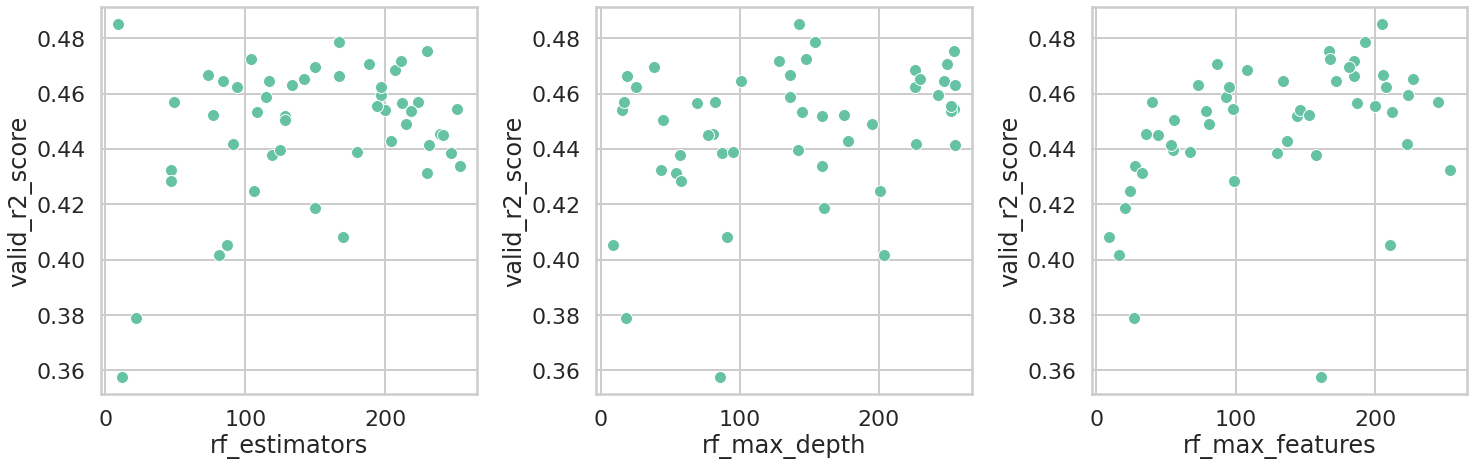

In [22]:
fig, ax = plt.subplots(1,3,figsize=(21,7))
sns.scatterplot(data=perf_df, x="rf_estimators", y="valid_r2_score", ax=ax[0])
sns.scatterplot(data=perf_df, x="rf_max_depth", y="valid_r2_score", ax=ax[1])
sns.scatterplot(data=perf_df, x="rf_max_features", y="valid_r2_score", ax=ax[2])
fig.tight_layout()

### Bayesian search

In [23]:
#define loss function
def lossfn(p):
    params["rf_estimators"] = int(p["rf_estimator"])
    params["rf_max_depth"] = int(p["rf_depth"])
    params["rf_max_features"] = int(p["rf_feature"])
    
    tparam = parse.wrapper(params)
    pl = mp.ModelPipeline(tparam)
    pl.train_model()
    perf_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
    pred_results = perf_data.get_prediction_results()
    r2 = pred_results['r2_score']
    return {'loss': 1-r2, 
            'status': STATUS_OK, 
            'model': tparam.model_tarball_path, 
            'rf_estimator': params["rf_estimators"],
            'rf_depth': params["rf_max_depth"],
            'rf_feature': params["rf_max_features"]}

space = {
    "rf_estimator": hp.uniform("rf_estimator", 8, 256),
    "rf_depth": hp.uniform("rf_depth", 8, 256),
    "rf_feature": hp.uniform("rf_feature", 8, 256)
}

In [24]:
trials = Trials()
best = fmin(lossfn, space, algo=tpe.suggest, max_evals=5, trials=trials)

  0%|          | 0/5 [00:00<?, ?it/s, best loss: ?]

2021-09-18 16:43:12,013 Attempting to load featurized dataset
2021-09-18 16:43:12,024 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:43:12,026 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:43:12,037 Featurizing sample 0
2021-09-18 16:43:17,178 Featurizing sample 1000


number of features: 1024
  0%|          | 0/5 [00:07<?, ?it/s, best loss: ?]

2021-09-18 16:43:19,217 Previous dataset split restored
2021-09-18 16:43:19,235 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/022a4de2-71bf-43d4-ab65-4c38f91c6e82/transformers.pkl
2021-09-18 16:43:19,237 Transforming response data
2021-09-18 16:43:19,274 Transforming response data
2021-09-18 16:43:19,291 Transforming response data
2021-09-18 16:43:19,327 Fitting random forest model
2021-09-18 16:43:20,004 Fold 0: training r2_score = 0.963, validation r2_score = 0.424, test r2_score = 0.514
2021-09-18 16:43:20,199 Wrote model tarball to ampl_output/H1_std_model_022a4de2-71bf-43d4-ab65-4c38f91c6e82.tar.gz


 20%|██        | 1/5 [00:08<00:32,  8.21s/it, best loss: 0.5758313410870676]

2021-09-18 16:43:20,221 Attempting to load featurized dataset
2021-09-18 16:43:20,230 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:43:20,231 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:43:20,243 Featurizing sample 0
2021-09-18 16:43:25,328 Featurizing sample 1000


number of features: 1024
 20%|██        | 1/5 [00:15<00:32,  8.21s/it, best loss: 0.5758313410870676]

2021-09-18 16:43:27,261 Previous dataset split restored
2021-09-18 16:43:27,278 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/129ad3e4-200a-4c69-93c3-724cdf24abfe/transformers.pkl
2021-09-18 16:43:27,279 Transforming response data
2021-09-18 16:43:27,316 Transforming response data
2021-09-18 16:43:27,331 Transforming response data
2021-09-18 16:43:27,362 Fitting random forest model
2021-09-18 16:43:28,773 Fold 0: training r2_score = 0.966, validation r2_score = 0.466, test r2_score = 0.536
2021-09-18 16:43:29,263 Wrote model tarball to ampl_output/H1_std_model_129ad3e4-200a-4c69-93c3-724cdf24abfe.tar.gz


 40%|████      | 2/5 [00:17<00:26,  8.71s/it, best loss: 0.5342531744658509]

2021-09-18 16:43:29,285 Attempting to load featurized dataset
2021-09-18 16:43:29,294 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:43:29,296 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:43:29,306 Featurizing sample 0
2021-09-18 16:43:34,383 Featurizing sample 1000


number of features: 1024
 40%|████      | 2/5 [00:24<00:26,  8.71s/it, best loss: 0.5342531744658509]

2021-09-18 16:43:36,372 Previous dataset split restored
2021-09-18 16:43:36,389 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/75fae892-cdac-4e6d-bff5-427935eda949/transformers.pkl
2021-09-18 16:43:36,391 Transforming response data
2021-09-18 16:43:36,427 Transforming response data
2021-09-18 16:43:36,444 Transforming response data
2021-09-18 16:43:36,476 Fitting random forest model
2021-09-18 16:43:39,023 Fold 0: training r2_score = 0.967, validation r2_score = 0.464, test r2_score = 0.540
2021-09-18 16:43:39,753 Wrote model tarball to ampl_output/H1_std_model_75fae892-cdac-4e6d-bff5-427935eda949.tar.gz


 60%|██████    | 3/5 [00:27<00:19,  9.52s/it, best loss: 0.5342531744658509]

2021-09-18 16:43:39,774 Attempting to load featurized dataset
2021-09-18 16:43:39,784 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:43:39,785 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:43:39,795 Featurizing sample 0
2021-09-18 16:43:44,806 Featurizing sample 1000


number of features: 1024
 60%|██████    | 3/5 [00:34<00:19,  9.52s/it, best loss: 0.5342531744658509]

2021-09-18 16:43:46,765 Previous dataset split restored
2021-09-18 16:43:46,782 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/03826201-20a9-4fef-8bde-35ac60281465/transformers.pkl
2021-09-18 16:43:46,783 Transforming response data
2021-09-18 16:43:46,816 Transforming response data
2021-09-18 16:43:46,832 Transforming response data
2021-09-18 16:43:46,863 Fitting random forest model
2021-09-18 16:43:48,287 Fold 0: training r2_score = 0.967, validation r2_score = 0.461, test r2_score = 0.534
2021-09-18 16:43:48,806 Wrote model tarball to ampl_output/H1_std_model_03826201-20a9-4fef-8bde-35ac60281465.tar.gz


 80%|████████  | 4/5 [00:36<00:09,  9.34s/it, best loss: 0.5342531744658509]

2021-09-18 16:43:48,828 Attempting to load featurized dataset
2021-09-18 16:43:48,837 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:43:48,838 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:43:48,850 Featurizing sample 0
2021-09-18 16:43:53,964 Featurizing sample 1000


number of features: 1024
 80%|████████  | 4/5 [00:43<00:09,  9.34s/it, best loss: 0.5342531744658509]

2021-09-18 16:43:55,930 Previous dataset split restored
2021-09-18 16:43:55,947 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/8ff607a1-6597-42e9-b725-1ad8e505fcbe/transformers.pkl
2021-09-18 16:43:55,949 Transforming response data
2021-09-18 16:43:55,984 Transforming response data
2021-09-18 16:43:56,000 Transforming response data
2021-09-18 16:43:56,032 Fitting random forest model
2021-09-18 16:43:56,590 Fold 0: training r2_score = 0.959, validation r2_score = 0.485, test r2_score = 0.524
2021-09-18 16:43:56,662 Wrote model tarball to ampl_output/H1_std_model_8ff607a1-6597-42e9-b725-1ad8e505fcbe.tar.gz


100%|██████████| 5/5 [00:44<00:00,  8.93s/it, best loss: 0.5152785357644352]


(0.2, 0.6)

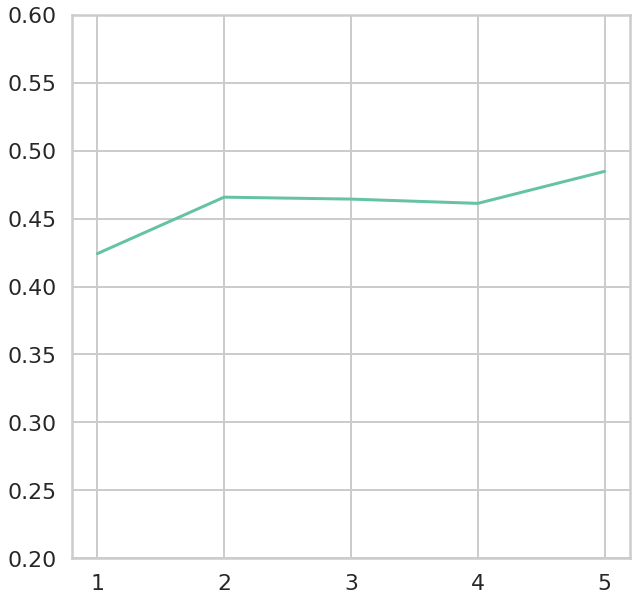

In [25]:
r2_list = [1-trials.trials[i]["result"]["loss"] for i in range(len(trials.trials))]
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.lineplot(x=list(range(1,len(trials.trials)+1)), y=r2_list, ax=ax)
ax.set_ylim(0.2,0.6)

In [26]:
rfe_list = [trials.trials[i]["result"]["rf_estimator"] for i in range(len(trials.trials))]
rfd_list = [trials.trials[i]["result"]["rf_depth"] for i in range(len(trials.trials))]
rff_list = [trials.trials[i]["result"]["rf_feature"] for i in range(len(trials.trials))]

In [27]:
perf_df = pd.DataFrame({"rf_estimators": rfe_list, "rf_max_depth": rfd_list, "rf_max_features": rff_list, "valid_r2_score": r2_list})
perf_df.sort_values(by="valid_r2_score", ascending=False)

,rf_estimators,rf_max_depth,rf_max_features,valid_r2_score
4,21,77,72,0.484721
1,172,32,115,0.465747
2,254,85,237,0.464318
3,179,87,109,0.461171
0,62,132,59,0.424169


#### Save Bayesian optimization trial object and continue later

In [28]:
# save the trial object
trial_file = os.path.join("hp_trial.pkl")
with open(trial_file, "wb") as f:
    pickle.dump(trials, f)

In [29]:
# load the trial object
with open(trial_file, "rb") as f:
    new_trials = pickle.load(f)

In [30]:
# continue HPO
best = fmin(lossfn, space, algo=tpe.suggest, max_evals=50, trials=new_trials)

  0%|          | 0/45 [00:00<?, ?it/s, best loss: ?]

2021-09-18 16:43:57,144 Attempting to load featurized dataset
2021-09-18 16:43:57,154 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:43:57,156 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:43:57,167 Featurizing sample 0
2021-09-18 16:44:02,244 Featurizing sample 1000


number of features: 1024
  0%|          | 0/45 [00:06<?, ?it/s, best loss: ?]

2021-09-18 16:44:04,148 Previous dataset split restored
2021-09-18 16:44:04,165 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/ef994b8a-e658-4b2c-8d9e-cef900a13fc8/transformers.pkl
2021-09-18 16:44:04,167 Transforming response data
2021-09-18 16:44:04,201 Transforming response data
2021-09-18 16:44:04,216 Transforming response data
2021-09-18 16:44:04,248 Fitting random forest model
2021-09-18 16:44:05,228 Fold 0: training r2_score = 0.966, validation r2_score = 0.459, test r2_score = 0.520
2021-09-18 16:44:05,464 Wrote model tarball to ampl_output/H1_std_model_ef994b8a-e658-4b2c-8d9e-cef900a13fc8.tar.gz


  2%|▏         | 1/45 [00:08<06:06,  8.34s/it, best loss: 0.5152785357644352]

2021-09-18 16:44:05,483 Attempting to load featurized dataset
2021-09-18 16:44:05,492 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:44:05,493 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:44:05,503 Featurizing sample 0
2021-09-18 16:44:10,463 Featurizing sample 1000


number of features: 1024
  2%|▏         | 1/45 [00:15<06:06,  8.34s/it, best loss: 0.5152785357644352]

2021-09-18 16:44:12,498 Previous dataset split restored
2021-09-18 16:44:12,514 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/f1b7cd6e-5ef1-40ad-b5d4-40ccba42ae22/transformers.pkl
2021-09-18 16:44:12,517 Transforming response data
2021-09-18 16:44:12,555 Transforming response data
2021-09-18 16:44:12,571 Transforming response data
2021-09-18 16:44:12,603 Fitting random forest model
2021-09-18 16:44:13,277 Fold 0: training r2_score = 0.964, validation r2_score = 0.425, test r2_score = 0.507
2021-09-18 16:44:13,448 Wrote model tarball to ampl_output/H1_std_model_f1b7cd6e-5ef1-40ad-b5d4-40ccba42ae22.tar.gz


  4%|▍         | 2/45 [00:16<05:49,  8.13s/it, best loss: 0.5152785357644352]

2021-09-18 16:44:13,466 Attempting to load featurized dataset
2021-09-18 16:44:13,475 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:44:13,476 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:44:13,487 Featurizing sample 0
2021-09-18 16:44:18,657 Featurizing sample 1000


number of features: 1024
  4%|▍         | 2/45 [00:23<05:49,  8.13s/it, best loss: 0.5152785357644352]

2021-09-18 16:44:20,641 Previous dataset split restored
2021-09-18 16:44:20,659 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/b7c14be1-5748-42ea-be43-3a07082ad6d8/transformers.pkl
2021-09-18 16:44:20,661 Transforming response data
2021-09-18 16:44:20,696 Transforming response data
2021-09-18 16:44:20,712 Transforming response data
2021-09-18 16:44:20,751 Fitting random forest model
2021-09-18 16:44:22,156 Fold 0: training r2_score = 0.966, validation r2_score = 0.453, test r2_score = 0.543
2021-09-18 16:44:22,578 Wrote model tarball to ampl_output/H1_std_model_b7c14be1-5748-42ea-be43-3a07082ad6d8.tar.gz


  7%|▋         | 3/45 [00:25<06:00,  8.59s/it, best loss: 0.5152785357644352]

2021-09-18 16:44:22,599 Attempting to load featurized dataset
2021-09-18 16:44:22,609 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:44:22,611 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:44:22,622 Featurizing sample 0
2021-09-18 16:44:27,634 Featurizing sample 1000


number of features: 1024
  7%|▋         | 3/45 [00:32<06:00,  8.59s/it, best loss: 0.5152785357644352]

2021-09-18 16:44:29,581 Previous dataset split restored
2021-09-18 16:44:29,599 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/8b13ec2b-0d8d-4ab8-b3d5-a471370fb56e/transformers.pkl
2021-09-18 16:44:29,600 Transforming response data
2021-09-18 16:44:29,634 Transforming response data
2021-09-18 16:44:29,648 Transforming response data
2021-09-18 16:44:29,680 Fitting random forest model
2021-09-18 16:44:30,989 Fold 0: training r2_score = 0.958, validation r2_score = 0.461, test r2_score = 0.551
2021-09-18 16:44:31,379 Wrote model tarball to ampl_output/H1_std_model_8b13ec2b-0d8d-4ab8-b3d5-a471370fb56e.tar.gz


  9%|▉         | 4/45 [00:34<05:55,  8.67s/it, best loss: 0.5152785357644352]

2021-09-18 16:44:31,400 Attempting to load featurized dataset
2021-09-18 16:44:31,408 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:44:31,409 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:44:31,421 Featurizing sample 0
2021-09-18 16:44:36,542 Featurizing sample 1000


number of features: 1024
  9%|▉         | 4/45 [00:41<05:55,  8.67s/it, best loss: 0.5152785357644352]

2021-09-18 16:44:38,511 Previous dataset split restored
2021-09-18 16:44:38,530 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/22f4a92b-d7c6-40a5-bf96-2bb130f51746/transformers.pkl
2021-09-18 16:44:38,533 Transforming response data
2021-09-18 16:44:38,567 Transforming response data
2021-09-18 16:44:38,583 Transforming response data
2021-09-18 16:44:38,616 Fitting random forest model
2021-09-18 16:44:39,956 Fold 0: training r2_score = 0.966, validation r2_score = 0.439, test r2_score = 0.533
2021-09-18 16:44:40,575 Wrote model tarball to ampl_output/H1_std_model_22f4a92b-d7c6-40a5-bf96-2bb130f51746.tar.gz


 11%|█         | 5/45 [00:43<05:54,  8.86s/it, best loss: 0.5152785357644352]

2021-09-18 16:44:40,595 Attempting to load featurized dataset
2021-09-18 16:44:40,603 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:44:40,604 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:44:40,615 Featurizing sample 0
2021-09-18 16:44:45,579 Featurizing sample 1000


number of features: 1024
 11%|█         | 5/45 [00:50<05:54,  8.86s/it, best loss: 0.5152785357644352]

2021-09-18 16:44:47,530 Previous dataset split restored
2021-09-18 16:44:47,547 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/d7a21b60-320a-43cd-96c2-39537b5bff1d/transformers.pkl
2021-09-18 16:44:47,548 Transforming response data
2021-09-18 16:44:47,582 Transforming response data
2021-09-18 16:44:47,597 Transforming response data
2021-09-18 16:44:47,629 Fitting random forest model
2021-09-18 16:44:48,396 Fold 0: training r2_score = 0.964, validation r2_score = 0.447, test r2_score = 0.535
2021-09-18 16:44:48,551 Wrote model tarball to ampl_output/H1_std_model_d7a21b60-320a-43cd-96c2-39537b5bff1d.tar.gz


 13%|█▎        | 6/45 [00:51<05:33,  8.56s/it, best loss: 0.5152785357644352]

2021-09-18 16:44:48,570 Attempting to load featurized dataset
2021-09-18 16:44:48,578 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:44:48,579 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:44:48,589 Featurizing sample 0
2021-09-18 16:44:53,709 Featurizing sample 1000


number of features: 1024
 13%|█▎        | 6/45 [00:58<05:33,  8.56s/it, best loss: 0.5152785357644352]

2021-09-18 16:44:55,728 Previous dataset split restored
2021-09-18 16:44:55,745 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/aceb15b2-0322-48eb-b510-870e1563ebed/transformers.pkl
2021-09-18 16:44:55,746 Transforming response data
2021-09-18 16:44:55,780 Transforming response data
2021-09-18 16:44:55,798 Transforming response data
2021-09-18 16:44:55,828 Fitting random forest model
2021-09-18 16:44:58,082 Fold 0: training r2_score = 0.967, validation r2_score = 0.467, test r2_score = 0.546
2021-09-18 16:44:58,797 Wrote model tarball to ampl_output/H1_std_model_aceb15b2-0322-48eb-b510-870e1563ebed.tar.gz


 16%|█▌        | 7/45 [01:01<05:46,  9.11s/it, best loss: 0.5152785357644352]

2021-09-18 16:44:58,818 Attempting to load featurized dataset
2021-09-18 16:44:58,826 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:44:58,828 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:44:58,841 Featurizing sample 0
2021-09-18 16:45:03,785 Featurizing sample 1000


number of features: 1024
 16%|█▌        | 7/45 [01:08<05:46,  9.11s/it, best loss: 0.5152785357644352]

2021-09-18 16:45:05,745 Previous dataset split restored
2021-09-18 16:45:05,762 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/5e4be55f-8462-4f15-b222-24f91ee5bcc5/transformers.pkl
2021-09-18 16:45:05,764 Transforming response data
2021-09-18 16:45:05,797 Transforming response data
2021-09-18 16:45:05,813 Transforming response data
2021-09-18 16:45:05,843 Fitting random forest model
2021-09-18 16:45:07,768 Fold 0: training r2_score = 0.966, validation r2_score = 0.464, test r2_score = 0.534
2021-09-18 16:45:08,317 Wrote model tarball to ampl_output/H1_std_model_5e4be55f-8462-4f15-b222-24f91ee5bcc5.tar.gz


 18%|█▊        | 8/45 [01:11<05:41,  9.24s/it, best loss: 0.5152785357644352]

2021-09-18 16:45:08,338 Attempting to load featurized dataset
2021-09-18 16:45:08,347 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:45:08,349 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:45:08,361 Featurizing sample 0
2021-09-18 16:45:13,525 Featurizing sample 1000


number of features: 1024
 18%|█▊        | 8/45 [01:18<05:41,  9.24s/it, best loss: 0.5152785357644352]

2021-09-18 16:45:15,536 Previous dataset split restored
2021-09-18 16:45:15,554 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/d021982f-04ba-44cc-adac-ab0a6806f9e6/transformers.pkl
2021-09-18 16:45:15,556 Transforming response data
2021-09-18 16:45:15,587 Transforming response data
2021-09-18 16:45:15,602 Transforming response data
2021-09-18 16:45:15,635 Fitting random forest model
2021-09-18 16:45:17,266 Fold 0: training r2_score = 0.966, validation r2_score = 0.473, test r2_score = 0.550
2021-09-18 16:45:17,767 Wrote model tarball to ampl_output/H1_std_model_d021982f-04ba-44cc-adac-ab0a6806f9e6.tar.gz


 20%|██        | 9/45 [01:20<05:35,  9.31s/it, best loss: 0.5152785357644352]

2021-09-18 16:45:17,792 Attempting to load featurized dataset
2021-09-18 16:45:17,801 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:45:17,802 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:45:17,815 Featurizing sample 0
2021-09-18 16:45:22,775 Featurizing sample 1000


number of features: 1024
 20%|██        | 9/45 [01:27<05:35,  9.31s/it, best loss: 0.5152785357644352]

2021-09-18 16:45:24,718 Previous dataset split restored
2021-09-18 16:45:24,735 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/f77a8656-5fed-47c0-8d2a-ff5bc7048f5c/transformers.pkl
2021-09-18 16:45:24,736 Transforming response data
2021-09-18 16:45:24,771 Transforming response data
2021-09-18 16:45:24,785 Transforming response data
2021-09-18 16:45:24,815 Fitting random forest model
2021-09-18 16:45:25,898 Fold 0: training r2_score = 0.966, validation r2_score = 0.441, test r2_score = 0.535
2021-09-18 16:45:26,130 Wrote model tarball to ampl_output/H1_std_model_f77a8656-5fed-47c0-8d2a-ff5bc7048f5c.tar.gz


 22%|██▏       | 10/45 [01:29<05:15,  9.01s/it, best loss: 0.5152785357644352]

2021-09-18 16:45:26,150 Attempting to load featurized dataset
2021-09-18 16:45:26,159 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:45:26,161 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:45:26,172 Featurizing sample 0
2021-09-18 16:45:31,326 Featurizing sample 1000


number of features: 1024
 22%|██▏       | 10/45 [01:36<05:15,  9.01s/it, best loss: 0.5152785357644352]

2021-09-18 16:45:33,341 Previous dataset split restored
2021-09-18 16:45:33,357 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/9b2e31b1-cb2d-4b86-aeb8-7395a7e67485/transformers.pkl
2021-09-18 16:45:33,359 Transforming response data
2021-09-18 16:45:33,394 Transforming response data
2021-09-18 16:45:33,411 Transforming response data
2021-09-18 16:45:33,446 Fitting random forest model
2021-09-18 16:45:34,227 Fold 0: training r2_score = 0.964, validation r2_score = 0.404, test r2_score = 0.505
2021-09-18 16:45:34,491 Wrote model tarball to ampl_output/H1_std_model_9b2e31b1-cb2d-4b86-aeb8-7395a7e67485.tar.gz


 24%|██▍       | 11/45 [01:37<04:59,  8.81s/it, best loss: 0.5152785357644352]

2021-09-18 16:45:34,514 Attempting to load featurized dataset
2021-09-18 16:45:34,525 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:45:34,527 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:45:34,540 Featurizing sample 0
2021-09-18 16:45:39,682 Featurizing sample 1000


number of features: 1024
 24%|██▍       | 11/45 [01:44<04:59,  8.81s/it, best loss: 0.5152785357644352]

2021-09-18 16:45:41,638 Previous dataset split restored
2021-09-18 16:45:41,655 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/f14776d6-b99f-4b2a-a996-223d3d2b5403/transformers.pkl
2021-09-18 16:45:41,657 Transforming response data
2021-09-18 16:45:41,690 Transforming response data
2021-09-18 16:45:41,706 Transforming response data
2021-09-18 16:45:41,736 Fitting random forest model
2021-09-18 16:45:43,057 Fold 0: training r2_score = 0.967, validation r2_score = 0.450, test r2_score = 0.542
2021-09-18 16:45:43,607 Wrote model tarball to ampl_output/H1_std_model_f14776d6-b99f-4b2a-a996-223d3d2b5403.tar.gz


 27%|██▋       | 12/45 [01:46<04:53,  8.91s/it, best loss: 0.5152785357644352]

2021-09-18 16:45:43,627 Attempting to load featurized dataset
2021-09-18 16:45:43,635 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:45:43,636 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:45:43,646 Featurizing sample 0
2021-09-18 16:45:48,670 Featurizing sample 1000


number of features: 1024
 27%|██▋       | 12/45 [01:53<04:53,  8.91s/it, best loss: 0.5152785357644352]

2021-09-18 16:45:50,694 Previous dataset split restored
2021-09-18 16:45:50,710 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/5a55f8ef-5504-4391-bc0f-aa3a0b999cd7/transformers.pkl
2021-09-18 16:45:50,712 Transforming response data
2021-09-18 16:45:50,746 Transforming response data
2021-09-18 16:45:50,761 Transforming response data
2021-09-18 16:45:50,791 Fitting random forest model
2021-09-18 16:45:52,304 Fold 0: training r2_score = 0.965, validation r2_score = 0.452, test r2_score = 0.519
2021-09-18 16:45:52,742 Wrote model tarball to ampl_output/H1_std_model_5a55f8ef-5504-4391-bc0f-aa3a0b999cd7.tar.gz


 29%|██▉       | 13/45 [01:55<04:47,  8.98s/it, best loss: 0.5152785357644352]

2021-09-18 16:45:53,139 Attempting to load featurized dataset
2021-09-18 16:45:53,154 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:45:53,157 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:45:53,168 Featurizing sample 0
2021-09-18 16:45:58,261 Featurizing sample 1000


number of features: 1024
 29%|██▉       | 13/45 [02:02<04:47,  8.98s/it, best loss: 0.5152785357644352]

2021-09-18 16:46:00,204 Previous dataset split restored
2021-09-18 16:46:00,221 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/dde384b3-20d7-49fa-9d6d-a2dde800dd4d/transformers.pkl
2021-09-18 16:46:00,222 Transforming response data
2021-09-18 16:46:00,255 Transforming response data
2021-09-18 16:46:00,270 Transforming response data
2021-09-18 16:46:00,301 Fitting random forest model
2021-09-18 16:46:00,759 Fold 0: training r2_score = 0.957, validation r2_score = 0.382, test r2_score = 0.485
2021-09-18 16:46:00,824 Wrote model tarball to ampl_output/H1_std_model_dde384b3-20d7-49fa-9d6d-a2dde800dd4d.tar.gz


 31%|███       | 14/45 [02:03<04:29,  8.71s/it, best loss: 0.5152785357644352]

2021-09-18 16:46:00,841 Attempting to load featurized dataset
2021-09-18 16:46:00,849 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:46:00,852 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:46:00,862 Featurizing sample 0
2021-09-18 16:46:05,840 Featurizing sample 1000


number of features: 1024
 31%|███       | 14/45 [02:10<04:29,  8.71s/it, best loss: 0.5152785357644352]

2021-09-18 16:46:07,817 Previous dataset split restored
2021-09-18 16:46:07,834 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/eec709e3-0ff2-46e7-a0e4-86fafe323360/transformers.pkl
2021-09-18 16:46:07,837 Transforming response data
2021-09-18 16:46:07,873 Transforming response data
2021-09-18 16:46:07,890 Transforming response data
2021-09-18 16:46:07,924 Fitting random forest model
2021-09-18 16:46:08,900 Fold 0: training r2_score = 0.965, validation r2_score = 0.472, test r2_score = 0.550
2021-09-18 16:46:09,090 Wrote model tarball to ampl_output/H1_std_model_eec709e3-0ff2-46e7-a0e4-86fafe323360.tar.gz


 33%|███▎      | 15/45 [02:11<04:17,  8.57s/it, best loss: 0.5152785357644352]

2021-09-18 16:46:09,122 Attempting to load featurized dataset
2021-09-18 16:46:09,130 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:46:09,132 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:46:09,145 Featurizing sample 0
2021-09-18 16:46:14,405 Featurizing sample 1000


number of features: 1024
 33%|███▎      | 15/45 [02:19<04:17,  8.57s/it, best loss: 0.5152785357644352]

2021-09-18 16:46:16,392 Previous dataset split restored
2021-09-18 16:46:16,409 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/16984aa8-1e7a-4ee5-ba37-6c4465012641/transformers.pkl
2021-09-18 16:46:16,411 Transforming response data
2021-09-18 16:46:16,446 Transforming response data
2021-09-18 16:46:16,461 Transforming response data
2021-09-18 16:46:16,492 Fitting random forest model
2021-09-18 16:46:17,481 Fold 0: training r2_score = 0.966, validation r2_score = 0.438, test r2_score = 0.529
2021-09-18 16:46:17,820 Wrote model tarball to ampl_output/H1_std_model_16984aa8-1e7a-4ee5-ba37-6c4465012641.tar.gz


 36%|███▌      | 16/45 [02:20<04:09,  8.62s/it, best loss: 0.5152785357644352]

2021-09-18 16:46:17,855 Attempting to load featurized dataset
2021-09-18 16:46:17,864 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:46:17,866 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:46:17,880 Featurizing sample 0
2021-09-18 16:46:22,869 Featurizing sample 1000


number of features: 1024
 36%|███▌      | 16/45 [02:27<04:09,  8.62s/it, best loss: 0.5152785357644352]

2021-09-18 16:46:24,826 Previous dataset split restored
2021-09-18 16:46:24,845 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/e71edba3-1fdd-4dea-918c-ae5ba92f5bbe/transformers.pkl
2021-09-18 16:46:24,846 Transforming response data
2021-09-18 16:46:24,879 Transforming response data
2021-09-18 16:46:24,896 Transforming response data
2021-09-18 16:46:24,926 Fitting random forest model
2021-09-18 16:46:26,023 Fold 0: training r2_score = 0.966, validation r2_score = 0.459, test r2_score = 0.527
2021-09-18 16:46:26,392 Wrote model tarball to ampl_output/H1_std_model_e71edba3-1fdd-4dea-918c-ae5ba92f5bbe.tar.gz


 38%|███▊      | 17/45 [02:29<04:00,  8.61s/it, best loss: 0.5152785357644352]

2021-09-18 16:46:26,419 Attempting to load featurized dataset
2021-09-18 16:46:26,428 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:46:26,430 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:46:26,441 Featurizing sample 0
2021-09-18 16:46:31,681 Featurizing sample 1000


number of features: 1024
 38%|███▊      | 17/45 [02:36<04:00,  8.61s/it, best loss: 0.5152785357644352]

2021-09-18 16:46:33,707 Previous dataset split restored
2021-09-18 16:46:33,726 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/8ecc54cc-3536-4800-97cb-5dfe0bc1022a/transformers.pkl
2021-09-18 16:46:33,729 Transforming response data
2021-09-18 16:46:33,762 Transforming response data
2021-09-18 16:46:33,778 Transforming response data
2021-09-18 16:46:33,809 Fitting random forest model
2021-09-18 16:46:35,848 Fold 0: training r2_score = 0.966, validation r2_score = 0.467, test r2_score = 0.550
2021-09-18 16:46:36,465 Wrote model tarball to ampl_output/H1_std_model_8ecc54cc-3536-4800-97cb-5dfe0bc1022a.tar.gz


 40%|████      | 18/45 [02:39<04:04,  9.05s/it, best loss: 0.5152785357644352]

2021-09-18 16:46:36,493 Attempting to load featurized dataset
2021-09-18 16:46:36,501 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:46:36,502 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:46:36,513 Featurizing sample 0
2021-09-18 16:46:41,541 Featurizing sample 1000


number of features: 1024
 40%|████      | 18/45 [02:46<04:04,  9.05s/it, best loss: 0.5152785357644352]

2021-09-18 16:46:43,499 Previous dataset split restored
2021-09-18 16:46:43,518 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/e613fe42-82bd-4410-99d4-98b4ef22260f/transformers.pkl
2021-09-18 16:46:43,520 Transforming response data
2021-09-18 16:46:43,554 Transforming response data
2021-09-18 16:46:43,570 Transforming response data
2021-09-18 16:46:43,600 Fitting random forest model
2021-09-18 16:46:44,158 Fold 0: training r2_score = 0.960, validation r2_score = 0.437, test r2_score = 0.566
2021-09-18 16:46:44,229 Wrote model tarball to ampl_output/H1_std_model_e613fe42-82bd-4410-99d4-98b4ef22260f.tar.gz


 42%|████▏     | 19/45 [02:47<03:45,  8.66s/it, best loss: 0.5152785357644352]

2021-09-18 16:46:44,254 Attempting to load featurized dataset
2021-09-18 16:46:44,263 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:46:44,264 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:46:44,276 Featurizing sample 0
2021-09-18 16:46:49,429 Featurizing sample 1000


number of features: 1024
 42%|████▏     | 19/45 [02:54<03:45,  8.66s/it, best loss: 0.5152785357644352]

2021-09-18 16:46:51,461 Previous dataset split restored
2021-09-18 16:46:51,478 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/2b5531ac-38ec-44bb-ae77-302c6bf6baf8/transformers.pkl
2021-09-18 16:46:51,480 Transforming response data
2021-09-18 16:46:51,513 Transforming response data
2021-09-18 16:46:51,530 Transforming response data
2021-09-18 16:46:51,562 Fitting random forest model
2021-09-18 16:46:53,304 Fold 0: training r2_score = 0.966, validation r2_score = 0.448, test r2_score = 0.531
2021-09-18 16:46:53,952 Wrote model tarball to ampl_output/H1_std_model_2b5531ac-38ec-44bb-ae77-302c6bf6baf8.tar.gz


 44%|████▍     | 20/45 [02:56<03:44,  8.98s/it, best loss: 0.5152785357644352]

2021-09-18 16:46:53,980 Attempting to load featurized dataset
2021-09-18 16:46:53,990 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:46:53,991 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:46:54,003 Featurizing sample 0
2021-09-18 16:46:59,040 Featurizing sample 1000


number of features: 1024
 44%|████▍     | 20/45 [03:03<03:44,  8.98s/it, best loss: 0.5152785357644352]

2021-09-18 16:47:00,984 Previous dataset split restored
2021-09-18 16:47:01,000 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/e79b0820-591a-4ff3-978d-7e085e77684c/transformers.pkl
2021-09-18 16:47:01,002 Transforming response data
2021-09-18 16:47:01,035 Transforming response data
2021-09-18 16:47:01,050 Transforming response data
2021-09-18 16:47:01,084 Fitting random forest model
2021-09-18 16:47:02,072 Fold 0: training r2_score = 0.966, validation r2_score = 0.474, test r2_score = 0.550
2021-09-18 16:47:02,402 Wrote model tarball to ampl_output/H1_std_model_e79b0820-591a-4ff3-978d-7e085e77684c.tar.gz


 47%|████▋     | 21/45 [03:05<03:31,  8.82s/it, best loss: 0.5152785357644352]

2021-09-18 16:47:02,431 Attempting to load featurized dataset
2021-09-18 16:47:02,441 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:47:02,443 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:47:02,454 Featurizing sample 0
2021-09-18 16:47:07,566 Featurizing sample 1000


number of features: 1024
 47%|████▋     | 21/45 [03:12<03:31,  8.82s/it, best loss: 0.5152785357644352]

2021-09-18 16:47:09,605 Previous dataset split restored
2021-09-18 16:47:09,623 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/51b81b6b-8afe-4341-9e47-e23a5728105b/transformers.pkl
2021-09-18 16:47:09,624 Transforming response data
2021-09-18 16:47:09,658 Transforming response data
2021-09-18 16:47:09,673 Transforming response data
2021-09-18 16:47:09,704 Fitting random forest model
2021-09-18 16:47:10,268 Fold 0: training r2_score = 0.960, validation r2_score = 0.437, test r2_score = 0.523
2021-09-18 16:47:10,378 Wrote model tarball to ampl_output/H1_std_model_51b81b6b-8afe-4341-9e47-e23a5728105b.tar.gz


 49%|████▉     | 22/45 [03:13<03:17,  8.57s/it, best loss: 0.5152785357644352]

2021-09-18 16:47:10,406 Attempting to load featurized dataset
2021-09-18 16:47:10,417 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:47:10,418 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:47:10,432 Featurizing sample 0
2021-09-18 16:47:15,594 Featurizing sample 1000


number of features: 1024
 49%|████▉     | 22/45 [03:20<03:17,  8.57s/it, best loss: 0.5152785357644352]

2021-09-18 16:47:17,523 Previous dataset split restored
2021-09-18 16:47:17,541 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/a3564911-5139-4145-9ad7-98cccbe0913e/transformers.pkl
2021-09-18 16:47:17,542 Transforming response data
2021-09-18 16:47:17,576 Transforming response data
2021-09-18 16:47:17,591 Transforming response data
2021-09-18 16:47:17,622 Fitting random forest model
2021-09-18 16:47:18,407 Fold 0: training r2_score = 0.965, validation r2_score = 0.415, test r2_score = 0.504
2021-09-18 16:47:18,738 Wrote model tarball to ampl_output/H1_std_model_a3564911-5139-4145-9ad7-98cccbe0913e.tar.gz


 51%|█████     | 23/45 [03:21<03:07,  8.51s/it, best loss: 0.5152785357644352]

2021-09-18 16:47:18,763 Attempting to load featurized dataset
2021-09-18 16:47:18,772 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:47:18,773 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:47:18,785 Featurizing sample 0
2021-09-18 16:47:23,789 Featurizing sample 1000


number of features: 1024
 51%|█████     | 23/45 [03:28<03:07,  8.51s/it, best loss: 0.5152785357644352]

2021-09-18 16:47:25,717 Previous dataset split restored
2021-09-18 16:47:25,734 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/035abf27-3d7e-4a8c-a236-6e5984abb6d4/transformers.pkl
2021-09-18 16:47:25,736 Transforming response data
2021-09-18 16:47:25,765 Transforming response data
2021-09-18 16:47:25,779 Transforming response data
2021-09-18 16:47:25,811 Fitting random forest model
2021-09-18 16:47:26,380 Fold 0: training r2_score = 0.962, validation r2_score = 0.440, test r2_score = 0.549
2021-09-18 16:47:26,503 Wrote model tarball to ampl_output/H1_std_model_035abf27-3d7e-4a8c-a236-6e5984abb6d4.tar.gz


 53%|█████▎    | 24/45 [03:29<02:53,  8.28s/it, best loss: 0.5152785357644352]

2021-09-18 16:47:26,530 Attempting to load featurized dataset
2021-09-18 16:47:26,539 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:47:26,540 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:47:26,551 Featurizing sample 0
2021-09-18 16:47:31,831 Featurizing sample 1000


number of features: 1024
 53%|█████▎    | 24/45 [03:36<02:53,  8.28s/it, best loss: 0.5152785357644352]

2021-09-18 16:47:33,864 Previous dataset split restored
2021-09-18 16:47:33,882 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/c69f6680-8183-4ad2-8723-0f0822aaa1db/transformers.pkl
2021-09-18 16:47:33,883 Transforming response data
2021-09-18 16:47:33,912 Transforming response data
2021-09-18 16:47:33,928 Transforming response data
2021-09-18 16:47:33,961 Fitting random forest model
2021-09-18 16:47:35,052 Fold 0: training r2_score = 0.965, validation r2_score = 0.463, test r2_score = 0.543
2021-09-18 16:47:35,357 Wrote model tarball to ampl_output/H1_std_model_c69f6680-8183-4ad2-8723-0f0822aaa1db.tar.gz


 56%|█████▌    | 25/45 [03:38<02:49,  8.45s/it, best loss: 0.5152785357644352]

2021-09-18 16:47:35,388 Attempting to load featurized dataset
2021-09-18 16:47:35,398 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:47:35,400 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:47:35,412 Featurizing sample 0
2021-09-18 16:47:40,514 Featurizing sample 1000


number of features: 1024
 56%|█████▌    | 25/45 [03:45<02:49,  8.45s/it, best loss: 0.5152785357644352]

2021-09-18 16:47:42,454 Previous dataset split restored
2021-09-18 16:47:42,473 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/1c55e483-222e-429a-ab3d-ff20a27a6d99/transformers.pkl
2021-09-18 16:47:42,475 Transforming response data
2021-09-18 16:47:42,502 Transforming response data
2021-09-18 16:47:42,516 Transforming response data
2021-09-18 16:47:42,550 Fitting random forest model
2021-09-18 16:47:43,002 Fold 0: training r2_score = 0.951, validation r2_score = 0.361, test r2_score = 0.468
2021-09-18 16:47:43,038 Wrote model tarball to ampl_output/H1_std_model_1c55e483-222e-429a-ab3d-ff20a27a6d99.tar.gz


 58%|█████▊    | 26/45 [03:45<02:36,  8.22s/it, best loss: 0.5152785357644352]

2021-09-18 16:47:43,068 Attempting to load featurized dataset
2021-09-18 16:47:43,079 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:47:43,080 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:47:43,092 Featurizing sample 0
2021-09-18 16:47:48,216 Featurizing sample 1000


number of features: 1024
 58%|█████▊    | 26/45 [03:52<02:36,  8.22s/it, best loss: 0.5152785357644352]

2021-09-18 16:47:50,221 Previous dataset split restored
2021-09-18 16:47:50,238 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/b4b353d1-9691-44cb-8466-9bb8aab8d12a/transformers.pkl
2021-09-18 16:47:50,240 Transforming response data
2021-09-18 16:47:50,270 Transforming response data
2021-09-18 16:47:50,287 Transforming response data
2021-09-18 16:47:50,321 Fitting random forest model
2021-09-18 16:47:51,008 Fold 0: training r2_score = 0.741, validation r2_score = 0.276, test r2_score = 0.380
2021-09-18 16:47:51,135 Wrote model tarball to ampl_output/H1_std_model_b4b353d1-9691-44cb-8466-9bb8aab8d12a.tar.gz


 60%|██████    | 27/45 [03:54<02:27,  8.19s/it, best loss: 0.5152785357644352]

2021-09-18 16:47:51,165 Attempting to load featurized dataset
2021-09-18 16:47:51,174 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:47:51,175 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:47:51,188 Featurizing sample 0
2021-09-18 16:47:56,286 Featurizing sample 1000


number of features: 1024
 60%|██████    | 27/45 [04:00<02:27,  8.19s/it, best loss: 0.5152785357644352]

2021-09-18 16:47:58,185 Previous dataset split restored
2021-09-18 16:47:58,204 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/7508f31b-1ff9-40f5-8534-5d4f53ed123c/transformers.pkl
2021-09-18 16:47:58,205 Transforming response data
2021-09-18 16:47:58,233 Transforming response data
2021-09-18 16:47:58,247 Transforming response data
2021-09-18 16:47:58,278 Fitting random forest model
2021-09-18 16:47:59,482 Fold 0: training r2_score = 0.966, validation r2_score = 0.457, test r2_score = 0.529
2021-09-18 16:47:59,865 Wrote model tarball to ampl_output/H1_std_model_7508f31b-1ff9-40f5-8534-5d4f53ed123c.tar.gz


 62%|██████▏   | 28/45 [04:02<02:21,  8.35s/it, best loss: 0.5152785357644352]

2021-09-18 16:47:59,891 Attempting to load featurized dataset
2021-09-18 16:47:59,900 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:47:59,901 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:47:59,912 Featurizing sample 0
2021-09-18 16:48:04,919 Featurizing sample 1000


number of features: 1024
 62%|██████▏   | 28/45 [04:09<02:21,  8.35s/it, best loss: 0.5152785357644352]

2021-09-18 16:48:06,938 Previous dataset split restored
2021-09-18 16:48:06,956 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/278e3396-a424-4109-94ac-9cee37758b36/transformers.pkl
2021-09-18 16:48:06,958 Transforming response data
2021-09-18 16:48:06,989 Transforming response data
2021-09-18 16:48:07,003 Transforming response data
2021-09-18 16:48:07,036 Fitting random forest model
2021-09-18 16:48:07,816 Fold 0: training r2_score = 0.965, validation r2_score = 0.448, test r2_score = 0.521
2021-09-18 16:48:08,026 Wrote model tarball to ampl_output/H1_std_model_278e3396-a424-4109-94ac-9cee37758b36.tar.gz


 64%|██████▍   | 29/45 [04:10<02:12,  8.29s/it, best loss: 0.5152785357644352]

2021-09-18 16:48:08,054 Attempting to load featurized dataset
2021-09-18 16:48:08,066 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:48:08,067 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:48:08,080 Featurizing sample 0
2021-09-18 16:48:13,303 Featurizing sample 1000


number of features: 1024
 64%|██████▍   | 29/45 [04:18<02:12,  8.29s/it, best loss: 0.5152785357644352]

2021-09-18 16:48:15,271 Previous dataset split restored
2021-09-18 16:48:15,288 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/03874e07-5f49-4ce7-8d6b-ce02b1a3c3ee/transformers.pkl
2021-09-18 16:48:15,290 Transforming response data
2021-09-18 16:48:15,318 Transforming response data
2021-09-18 16:48:15,333 Transforming response data
2021-09-18 16:48:15,364 Fitting random forest model
2021-09-18 16:48:16,027 Fold 0: training r2_score = 0.965, validation r2_score = 0.424, test r2_score = 0.516
2021-09-18 16:48:16,155 Wrote model tarball to ampl_output/H1_std_model_03874e07-5f49-4ce7-8d6b-ce02b1a3c3ee.tar.gz


 67%|██████▋   | 30/45 [04:19<02:03,  8.24s/it, best loss: 0.5152785357644352]

2021-09-18 16:48:16,179 Attempting to load featurized dataset
2021-09-18 16:48:16,188 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:48:16,189 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:48:16,200 Featurizing sample 0
2021-09-18 16:48:21,181 Featurizing sample 1000


number of features: 1024
 67%|██████▋   | 30/45 [04:25<02:03,  8.24s/it, best loss: 0.5152785357644352]

2021-09-18 16:48:23,081 Previous dataset split restored
2021-09-18 16:48:23,101 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/3421f11b-0fea-45c5-b494-f0783c4488d8/transformers.pkl
2021-09-18 16:48:23,102 Transforming response data
2021-09-18 16:48:23,129 Transforming response data
2021-09-18 16:48:23,143 Transforming response data
2021-09-18 16:48:23,174 Fitting random forest model
2021-09-18 16:48:24,074 Fold 0: training r2_score = 0.965, validation r2_score = 0.456, test r2_score = 0.538
2021-09-18 16:48:24,466 Wrote model tarball to ampl_output/H1_std_model_3421f11b-0fea-45c5-b494-f0783c4488d8.tar.gz


 69%|██████▉   | 31/45 [04:27<01:55,  8.26s/it, best loss: 0.5152785357644352]

2021-09-18 16:48:24,494 Attempting to load featurized dataset
2021-09-18 16:48:24,503 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:48:24,504 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:48:24,517 Featurizing sample 0
2021-09-18 16:48:29,694 Featurizing sample 1000


number of features: 1024
 69%|██████▉   | 31/45 [04:34<01:55,  8.26s/it, best loss: 0.5152785357644352]

2021-09-18 16:48:31,675 Previous dataset split restored
2021-09-18 16:48:31,692 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/870fbfda-7f4e-4639-817c-fee59e1f4a4b/transformers.pkl
2021-09-18 16:48:31,694 Transforming response data
2021-09-18 16:48:31,722 Transforming response data
2021-09-18 16:48:31,738 Transforming response data
2021-09-18 16:48:31,770 Fitting random forest model
2021-09-18 16:48:32,549 Fold 0: training r2_score = 0.965, validation r2_score = 0.443, test r2_score = 0.500
2021-09-18 16:48:32,767 Wrote model tarball to ampl_output/H1_std_model_870fbfda-7f4e-4639-817c-fee59e1f4a4b.tar.gz


 71%|███████   | 32/45 [04:35<01:47,  8.27s/it, best loss: 0.5152785357644352]

2021-09-18 16:48:32,796 Attempting to load featurized dataset
2021-09-18 16:48:32,806 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:48:32,808 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:48:32,820 Featurizing sample 0
2021-09-18 16:48:37,982 Featurizing sample 1000


number of features: 1024
 71%|███████   | 32/45 [04:42<01:47,  8.27s/it, best loss: 0.5152785357644352]

2021-09-18 16:48:39,985 Previous dataset split restored
2021-09-18 16:48:40,002 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/c87ee4e8-1589-4f59-bfab-74ccb3d776b8/transformers.pkl
2021-09-18 16:48:40,004 Transforming response data
2021-09-18 16:48:40,030 Transforming response data
2021-09-18 16:48:40,046 Transforming response data
2021-09-18 16:48:40,083 Fitting random forest model
2021-09-18 16:48:40,535 Fold 0: training r2_score = 0.952, validation r2_score = 0.418, test r2_score = 0.394
2021-09-18 16:48:40,574 Wrote model tarball to ampl_output/H1_std_model_c87ee4e8-1589-4f59-bfab-74ccb3d776b8.tar.gz


 73%|███████▎  | 33/45 [04:43<01:37,  8.13s/it, best loss: 0.5152785357644352]

2021-09-18 16:48:40,601 Attempting to load featurized dataset
2021-09-18 16:48:40,609 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:48:40,611 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:48:40,623 Featurizing sample 0
2021-09-18 16:48:45,751 Featurizing sample 1000


number of features: 1024
 73%|███████▎  | 33/45 [04:50<01:37,  8.13s/it, best loss: 0.5152785357644352]

2021-09-18 16:48:47,724 Previous dataset split restored
2021-09-18 16:48:47,744 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/9522f4f8-ffcc-4752-8d45-ef3f6f553aaa/transformers.pkl
2021-09-18 16:48:47,745 Transforming response data
2021-09-18 16:48:47,772 Transforming response data
2021-09-18 16:48:47,786 Transforming response data
2021-09-18 16:48:47,820 Fitting random forest model
2021-09-18 16:48:48,814 Fold 0: training r2_score = 0.965, validation r2_score = 0.440, test r2_score = 0.534
2021-09-18 16:48:49,114 Wrote model tarball to ampl_output/H1_std_model_9522f4f8-ffcc-4752-8d45-ef3f6f553aaa.tar.gz


 76%|███████▌  | 34/45 [04:51<01:30,  8.26s/it, best loss: 0.5152785357644352]

2021-09-18 16:48:49,148 Attempting to load featurized dataset
2021-09-18 16:48:49,158 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:48:49,159 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:48:49,171 Featurizing sample 0
2021-09-18 16:48:54,295 Featurizing sample 1000


number of features: 1024
 76%|███████▌  | 34/45 [04:58<01:30,  8.26s/it, best loss: 0.5152785357644352]

2021-09-18 16:48:56,216 Previous dataset split restored
2021-09-18 16:48:56,233 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/6deb1033-aae8-4889-b13b-6cc6d0ccb86b/transformers.pkl
2021-09-18 16:48:56,235 Transforming response data
2021-09-18 16:48:56,263 Transforming response data
2021-09-18 16:48:56,278 Transforming response data
2021-09-18 16:48:56,309 Fitting random forest model
2021-09-18 16:48:57,203 Fold 0: training r2_score = 0.965, validation r2_score = 0.428, test r2_score = 0.521
2021-09-18 16:48:57,552 Wrote model tarball to ampl_output/H1_std_model_6deb1033-aae8-4889-b13b-6cc6d0ccb86b.tar.gz


 78%|███████▊  | 35/45 [05:00<01:23,  8.31s/it, best loss: 0.5152785357644352]

2021-09-18 16:48:57,579 Attempting to load featurized dataset
2021-09-18 16:48:57,588 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:48:57,589 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:48:57,600 Featurizing sample 0
2021-09-18 16:49:02,541 Featurizing sample 1000


number of features: 1024
 78%|███████▊  | 35/45 [05:07<01:23,  8.31s/it, best loss: 0.5152785357644352]

2021-09-18 16:49:04,515 Previous dataset split restored
2021-09-18 16:49:04,534 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/31f4b55b-b808-4038-bb2b-c2291537b5fd/transformers.pkl
2021-09-18 16:49:04,537 Transforming response data
2021-09-18 16:49:04,567 Transforming response data
2021-09-18 16:49:04,584 Transforming response data
2021-09-18 16:49:04,617 Fitting random forest model
2021-09-18 16:49:06,565 Fold 0: training r2_score = 0.966, validation r2_score = 0.461, test r2_score = 0.531
2021-09-18 16:49:07,254 Wrote model tarball to ampl_output/H1_std_model_31f4b55b-b808-4038-bb2b-c2291537b5fd.tar.gz


 80%|████████  | 36/45 [05:10<01:18,  8.73s/it, best loss: 0.5152785357644352]

2021-09-18 16:49:07,288 Attempting to load featurized dataset
2021-09-18 16:49:07,299 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:49:07,301 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:49:07,314 Featurizing sample 0
2021-09-18 16:49:12,495 Featurizing sample 1000


number of features: 1024
 80%|████████  | 36/45 [05:17<01:18,  8.73s/it, best loss: 0.5152785357644352]

2021-09-18 16:49:14,445 Previous dataset split restored
2021-09-18 16:49:14,463 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/1529392d-7af0-40b6-a80b-5afc1c17d30c/transformers.pkl
2021-09-18 16:49:14,464 Transforming response data
2021-09-18 16:49:14,495 Transforming response data
2021-09-18 16:49:14,511 Transforming response data
2021-09-18 16:49:14,545 Fitting random forest model
2021-09-18 16:49:16,052 Fold 0: training r2_score = 0.966, validation r2_score = 0.466, test r2_score = 0.542
2021-09-18 16:49:16,463 Wrote model tarball to ampl_output/H1_std_model_1529392d-7af0-40b6-a80b-5afc1c17d30c.tar.gz


 82%|████████▏ | 37/45 [05:19<01:10,  8.87s/it, best loss: 0.5152785357644352]

2021-09-18 16:49:16,490 Attempting to load featurized dataset
2021-09-18 16:49:16,499 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:49:16,501 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:49:16,512 Featurizing sample 0
2021-09-18 16:49:21,498 Featurizing sample 1000


number of features: 1024
 82%|████████▏ | 37/45 [05:26<01:10,  8.87s/it, best loss: 0.5152785357644352]

2021-09-18 16:49:23,441 Previous dataset split restored
2021-09-18 16:49:23,458 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/83f66f63-f80e-4f86-8ead-0de4c01c9e9b/transformers.pkl
2021-09-18 16:49:23,460 Transforming response data
2021-09-18 16:49:23,487 Transforming response data
2021-09-18 16:49:23,501 Transforming response data
2021-09-18 16:49:23,531 Fitting random forest model
2021-09-18 16:49:24,860 Fold 0: training r2_score = 0.958, validation r2_score = 0.444, test r2_score = 0.528
2021-09-18 16:49:25,388 Wrote model tarball to ampl_output/H1_std_model_83f66f63-f80e-4f86-8ead-0de4c01c9e9b.tar.gz


 84%|████████▍ | 38/45 [05:28<01:02,  8.89s/it, best loss: 0.5152785357644352]

2021-09-18 16:49:25,421 Attempting to load featurized dataset
2021-09-18 16:49:25,430 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:49:25,431 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:49:25,443 Featurizing sample 0
2021-09-18 16:49:30,664 Featurizing sample 1000


number of features: 1024
 84%|████████▍ | 38/45 [05:35<01:02,  8.89s/it, best loss: 0.5152785357644352]

2021-09-18 16:49:32,653 Previous dataset split restored
2021-09-18 16:49:32,670 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/64d52313-6bd6-4046-a712-1bc002ad51cd/transformers.pkl
2021-09-18 16:49:32,672 Transforming response data
2021-09-18 16:49:32,701 Transforming response data
2021-09-18 16:49:32,714 Transforming response data
2021-09-18 16:49:32,746 Fitting random forest model
2021-09-18 16:49:34,361 Fold 0: training r2_score = 0.966, validation r2_score = 0.454, test r2_score = 0.524
2021-09-18 16:49:34,843 Wrote model tarball to ampl_output/H1_std_model_64d52313-6bd6-4046-a712-1bc002ad51cd.tar.gz


 87%|████████▋ | 39/45 [05:37<00:54,  9.06s/it, best loss: 0.5152785357644352]

2021-09-18 16:49:34,874 Attempting to load featurized dataset
2021-09-18 16:49:34,884 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:49:34,885 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:49:34,900 Featurizing sample 0
2021-09-18 16:49:39,957 Featurizing sample 1000


number of features: 1024
 87%|████████▋ | 39/45 [05:44<00:54,  9.06s/it, best loss: 0.5152785357644352]

2021-09-18 16:49:41,893 Previous dataset split restored
2021-09-18 16:49:41,913 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/9da7b45f-6859-4889-9f84-6694c2e232f3/transformers.pkl
2021-09-18 16:49:41,914 Transforming response data
2021-09-18 16:49:41,941 Transforming response data
2021-09-18 16:49:41,956 Transforming response data
2021-09-18 16:49:41,990 Fitting random forest model
2021-09-18 16:49:42,661 Fold 0: training r2_score = 0.964, validation r2_score = 0.433, test r2_score = 0.496
2021-09-18 16:49:42,824 Wrote model tarball to ampl_output/H1_std_model_9da7b45f-6859-4889-9f84-6694c2e232f3.tar.gz


 89%|████████▉ | 40/45 [05:45<00:43,  8.74s/it, best loss: 0.5152785357644352]

2021-09-18 16:49:42,852 Attempting to load featurized dataset
2021-09-18 16:49:42,862 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:49:42,864 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:49:42,875 Featurizing sample 0
2021-09-18 16:49:48,112 Featurizing sample 1000


number of features: 1024
 89%|████████▉ | 40/45 [05:52<00:43,  8.74s/it, best loss: 0.5152785357644352]

2021-09-18 16:49:50,141 Previous dataset split restored
2021-09-18 16:49:50,161 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/6ede6102-7fd1-4277-8a19-fa25ce2c408c/transformers.pkl
2021-09-18 16:49:50,162 Transforming response data
2021-09-18 16:49:50,190 Transforming response data
2021-09-18 16:49:50,207 Transforming response data
2021-09-18 16:49:50,240 Fitting random forest model
2021-09-18 16:49:51,666 Fold 0: training r2_score = 0.966, validation r2_score = 0.464, test r2_score = 0.543
2021-09-18 16:49:52,147 Wrote model tarball to ampl_output/H1_std_model_6ede6102-7fd1-4277-8a19-fa25ce2c408c.tar.gz


 91%|█████████ | 41/45 [05:55<00:35,  8.91s/it, best loss: 0.5152785357644352]

2021-09-18 16:49:52,179 Attempting to load featurized dataset
2021-09-18 16:49:52,189 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:49:52,190 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:49:52,202 Featurizing sample 0
2021-09-18 16:49:57,230 Featurizing sample 1000


number of features: 1024
 91%|█████████ | 41/45 [06:01<00:35,  8.91s/it, best loss: 0.5152785357644352]

2021-09-18 16:49:59,144 Previous dataset split restored
2021-09-18 16:49:59,162 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/b423e223-a9a4-4d2a-a1bd-3db0ca170a89/transformers.pkl
2021-09-18 16:49:59,165 Transforming response data
2021-09-18 16:49:59,194 Transforming response data
2021-09-18 16:49:59,209 Transforming response data
2021-09-18 16:49:59,241 Fitting random forest model
2021-09-18 16:49:59,801 Fold 0: training r2_score = 0.960, validation r2_score = 0.439, test r2_score = 0.511
2021-09-18 16:49:59,891 Wrote model tarball to ampl_output/H1_std_model_b423e223-a9a4-4d2a-a1bd-3db0ca170a89.tar.gz


 93%|█████████▎| 42/45 [06:02<00:25,  8.56s/it, best loss: 0.5152785357644352]

2021-09-18 16:49:59,921 Attempting to load featurized dataset
2021-09-18 16:49:59,931 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:49:59,932 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:49:59,945 Featurizing sample 0
2021-09-18 16:50:05,021 Featurizing sample 1000


number of features: 1024
 93%|█████████▎| 42/45 [06:09<00:25,  8.56s/it, best loss: 0.5152785357644352]

2021-09-18 16:50:07,020 Previous dataset split restored
2021-09-18 16:50:07,041 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/9ee16cb3-9752-42ff-b991-2a3707a081ce/transformers.pkl
2021-09-18 16:50:07,042 Transforming response data
2021-09-18 16:50:07,073 Transforming response data
2021-09-18 16:50:07,089 Transforming response data
2021-09-18 16:50:07,122 Fitting random forest model
2021-09-18 16:50:08,429 Fold 0: training r2_score = 0.967, validation r2_score = 0.462, test r2_score = 0.537
2021-09-18 16:50:08,847 Wrote model tarball to ampl_output/H1_std_model_9ee16cb3-9752-42ff-b991-2a3707a081ce.tar.gz


 96%|█████████▌| 43/45 [06:11<00:17,  8.68s/it, best loss: 0.5152785357644352]

2021-09-18 16:50:08,875 Attempting to load featurized dataset
2021-09-18 16:50:08,886 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:50:08,891 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:50:08,907 Featurizing sample 0
2021-09-18 16:50:13,999 Featurizing sample 1000


number of features: 1024
 96%|█████████▌| 43/45 [06:18<00:17,  8.68s/it, best loss: 0.5152785357644352]

2021-09-18 16:50:15,927 Previous dataset split restored
2021-09-18 16:50:15,945 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/44f01510-b305-4cb0-aafa-da2156c91967/transformers.pkl
2021-09-18 16:50:15,946 Transforming response data
2021-09-18 16:50:15,973 Transforming response data
2021-09-18 16:50:15,988 Transforming response data
2021-09-18 16:50:16,019 Fitting random forest model
2021-09-18 16:50:16,901 Fold 0: training r2_score = 0.928, validation r2_score = 0.446, test r2_score = 0.512
2021-09-18 16:50:17,046 Wrote model tarball to ampl_output/H1_std_model_44f01510-b305-4cb0-aafa-da2156c91967.tar.gz


 98%|█████████▊| 44/45 [06:19<00:08,  8.54s/it, best loss: 0.5152785357644352]

2021-09-18 16:50:17,076 Attempting to load featurized dataset
2021-09-18 16:50:17,086 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:50:17,088 Featurized dataset not previously saved for dataset H1_std, creating new
2021-09-18 16:50:17,099 Featurizing sample 0
2021-09-18 16:50:22,135 Featurizing sample 1000


number of features: 1024
 98%|█████████▊| 44/45 [06:26<00:08,  8.54s/it, best loss: 0.5152785357644352]

2021-09-18 16:50:24,136 Previous dataset split restored
2021-09-18 16:50:24,153 Wrote transformers to ampl_output/H1_std/RF_ecfp_scaffold_regression/c28a1381-84b5-4493-95c7-f1f967b375c3/transformers.pkl
2021-09-18 16:50:24,155 Transforming response data
2021-09-18 16:50:24,182 Transforming response data
2021-09-18 16:50:24,196 Transforming response data
2021-09-18 16:50:24,229 Fitting random forest model
2021-09-18 16:50:24,899 Fold 0: training r2_score = 0.965, validation r2_score = 0.488, test r2_score = 0.534
2021-09-18 16:50:25,073 Wrote model tarball to ampl_output/H1_std_model_c28a1381-84b5-4493-95c7-f1f967b375c3.tar.gz


100%|██████████| 45/45 [06:27<00:00,  8.62s/it, best loss: 0.5120841961932765]


(0.2, 0.6)

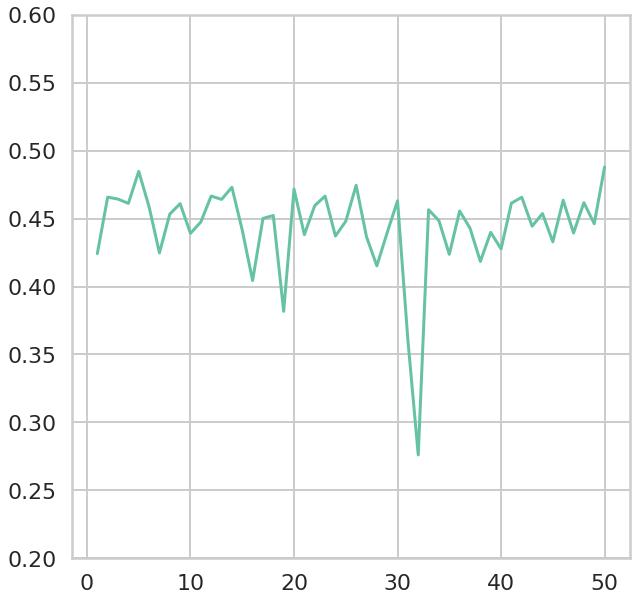

In [31]:
r2_list = [1-new_trials.trials[i]["result"]["loss"] for i in range(len(new_trials.trials))]
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.lineplot(x=list(range(1,len(new_trials.trials)+1)), y=r2_list, ax=ax)
ax.set_ylim(0.2,0.6)

In [32]:
rfe_list = [new_trials.trials[i]["result"]["rf_estimator"] for i in range(len(new_trials.trials))]
rfd_list = [new_trials.trials[i]["result"]["rf_depth"] for i in range(len(new_trials.trials))]
rff_list = [new_trials.trials[i]["result"]["rf_feature"] for i in range(len(new_trials.trials))]

In [33]:
perf_df = pd.DataFrame({"rf_estimators": rfe_list, "rf_max_depth": rfd_list, "rf_max_features": rff_list, "valid_r2_score": r2_list})
perf_df.sort_values(by="valid_r2_score", ascending=False)

,rf_estimators,rf_max_depth,rf_max_features,valid_r2_score
49,55,85,89,0.487916
4,21,77,72,0.484721
25,111,173,64,0.474472
13,174,172,142,0.473016
19,63,144,228,0.471687
11,250,93,183,0.466591
22,218,62,189,0.466535
1,172,32,115,0.465747
41,146,217,180,0.465680
2,254,85,237,0.464318


In [34]:
!date

Sat Sep 18 16:50:25 UTC 2021
